# Fraud Detection Project

**Author**: Sneha Kumar <br>

Python 3.11.5 has been used in this notebook. Additional files: 
- saved_objects folder : contains saved states of all the models. Please unzip the file and keep it in the same working directory as this notebook 
- autoencoder_tuning folder : contains the trials for autoencoder. Please unzip the file and keep it in the same working directory as this notebook 
- requirements.txt : list of libraries from the python environment used while running this notebook.

## Background

With the rapidly evolving capabilities of technology, financial fraud has emerged as one of the prevalent issues in the recent years. Whether through online banking, e-commerce platforms or credit cards, financial scams and fraud are become increasingly sophisticated and pervasive. In Singapore, scam victims lost over $380 million in just the first half of 2024, with scam cases increasing by 16.3% ([Sun, 2024](https://www.straitstimes.com/singapore/scam-victims-in-s-pore-lost-3856m-in-first-half-of-2024-as-number-of-cases-hit-high-of-26587)). Globally, 17% rise in digital fraud attacks in financial services has been reported ([Fintech News Singapore, 2024](https://fintechnews.sg/101575/regtech/fraud-attacks-financial-services-payment-account-creation-fraud/)). Detecting fraud has become more critical to safeguard individuals and prevent financial losses. With this motivation, I decided to explore what are the ways in which machine learning could be applied in detecting fraudulent transactions. While there are many forms of financial fraud, for the purposes of this project, we will be focusing only on credit card fraud. 

In the context of machine learning, the problem of fraud detection can be formulated in two different ways: 
1)	**Classification Problem**: A supervised learning task (binary classification), where given a set of input variables, the model would classify the transaction as normal or fraudulent. 

2)	**Anomaly Detection**: An unsupervised learning task, where common patterns of normal transactions are learnt by the model and use to identify data points that significantly deviate from these patterns as anomalies. The task can also be viewed as semi-supervised as data labels are used to guide in obtaining an optimal decision threshold for labelling anomalies. 


**The goal of this project is to compare these two formulations and determine which of them a) results in better perfomrnace & b) provides a better representation of the credit card fraud detection task.** 

## 1. Import Libraries

First, import all the necessary libraries, classes and functions that are used in this notebook

*Importing the libraries may take a couple minutes*

In [1]:
# FOR LOADING DATA #
import kagglehub

# HANDLING DIRECTORY
import os

# DATA MANIPULATION AND VISUALIZATION
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# FOR SUPERVISED LEARNING (CLASSIFICATION) ALGORITHMS #
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC

# DATA BALANCING #
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedBaggingClassifier

# FOR UNSUPERVISED LEARNING ALGORITHMS #
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# DATA SCALING #
from sklearn.preprocessing import StandardScaler

# MODEL PIPELINE #
from sklearn.pipeline import Pipeline

# MODEL TUNING AND EVALUATION #
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from keras_tuner import HyperModel, Tuner
from keras_tuner.oracles import BayesianOptimizationOracle

# SAVING/LOADING MODEL STATES #
import joblib
from keras.models import load_model

# PROGRESS TRACKER #
from tqdm import tqdm

2024-11-22 17:06:18.918741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Dataset Exploration

The [Credit Card Fraud](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) dataset sourced from Kaggle is used for this project. It contains over 280,000 credit card transaction records of European cardholders in September 2013. 

### 2.1 Import Data

The dataset is loaded into the workspace using Kaggle's API. 

In [2]:
# Download data using Kaggle's API (It may take 5-15 seconds for the first time, after which, the data will be cached)
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

# Check and print the data that has been loaded in the path
files = os.listdir(path)
print(files)

['creditcard.csv']


In [3]:
# Use os to join the path directory with the include the csv file's name 
data_file_path = os.path.join(path, files[0])

# Load the dataset as a Panda's dataframe with the full csv path
fraud_df = pd.read_csv(data_file_path)

# View the dataset
fraud_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
# Columns in the dataset
fraud_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

The dataset contains 284,807 transactions (rows) and 31 columns. From these 31 columns,
- `Time` denotes the time of transaction as seconds from the first transaction
- `Amount` is the amount of transaction (no currency described by the data source) 
-  Columns `V1-V28` are feature vectors obtained via PCA transformation (of a pre-existing raw data). These variables all correspond to some detail of transaction, but the variable names are masked by ‘V1’, ‘V2’, … for privacy reasons. 
- `Class` is the label of each transaction. `0` is a normal transaction, `1` is a fraudulent transaction. 

### 2.2 Basic Checks

A few more basic checks are also conducted on the dataset

2.2.1 Verify the data type of each of the columns. Based on the data description stated above/from the data source, each column should be of a numerical type. 

In [5]:
# Use df.dtypes to list data types of each column
fraud_df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

As expected, all the columns are float, except for the binary-valued `Class` column which is an integer. 

2.2.2 Missing data may lead to compatibility issues in model training for certain algorithms, incorrect/biased results, etc. So, it is important to check if there are any missing values in any of the columns. 

In [6]:
# Check if there are any missing/null/NA values in the dataframe using df.isna()
print(f"Total missing values in the dataframe: {fraud_df.isna().sum().sum()} ")    # we used .sum() twice to sum across all columns to check existence of missing values in the whole dataset (not just by each column)

Total missing values in the dataframe: 0 


There are no missing data points in the dataset, so there is no need to worry about removing NA values. 

2.2.3 The distribution of the data values can also be gauged using the 5-number statistcs. 

In [7]:
# df.describe() is used to check the counts in each column, and the mean, standard deviation, and 5 number statistics
fraud_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Some observations that can be made:
- The mean values for features `V1`-`V28` roughly hover around 0 
- Most of the features `V1`-`V28` have similar standard deviations, but some seem to have greater standard deviation (typically for ones with greater max-min range)
- The mean value of `Amount` is around 88 (larger than the 75th percentile) but the standard deviation is around 250. This suggest most transactions are small, but there are a very few very large transactions. 
- The mean value of `Class` is very close to 0, suggesting a data imbalance. 

However, just looking at these numbers may be too difficult to grasp and may not reveal the distributions as clearly. A better approach would be to visualize these values, as done in [Section 2.3](#23-data-distributions-visualizations).

### 2.3 Data Distributions (Visualizations)

In this section, the data distribution of the different columns is closely explored with the help of data visualizations. 

In [8]:
# Set the plot style for a clean and appealing design similar to R's ggplot2 library
plt.style.use('ggplot')

#### 2.3.1 Fraud Class

The distribution of the data points in the the `Class` column is plotted to find how many of them belong to each of the classes 0 and 1. Recall that 0 corresponds to normal transaction while 1 corresponds to fraudulent transaction. 

In [9]:
# Count the number of occurrences of each class (0 and 1) in the 'Class' column
fraud_counts = fraud_df['Class'].value_counts()

fraud_counts

Class
0    284315
1       492
Name: count, dtype: int64

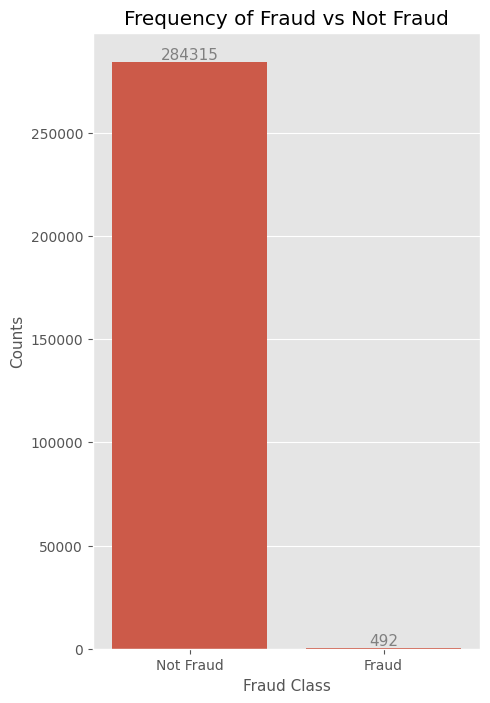

In [10]:
## Plot the number of occurences of each class with a bar chart ##

# Set size of the plot figure (width, height)
plt.figure(figsize=(5, 8))  
# Create a bar plot (count plot in seaborn) to visualize the distribution of the 'Class' column (Fraud vs Not Fraud)
ax = sns.countplot(x = 'Class', data=fraud_df)

#Set the title and axes labels 
plt.title('Frequency of Fraud vs Not Fraud')
plt.xlabel('Fraud Class', fontsize = 11)
plt.ylabel('Counts', fontsize = 11)

# Customize the x-axis ticks to denote labels 0 and 1 as 'Not Fraud' and 'Fraud' respectively
plt.xticks(ticks=[0, 1], labels=['Not Fraud', 'Fraud'])

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Get the count value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the label
                ha='center', va='center', fontsize=11, color = 'gray',  # Center align and set font size & color
                xytext=(0, 5),  # Add some vertical offset so the label doesn't overlap the bar
                textcoords='offset points')

# Display the plot
plt.show()

As see from the plot, the dataset is highly imbalanced. <br>
To visualize the chart better, a logarithmic scale for the y-axis can also be used for the counts. 

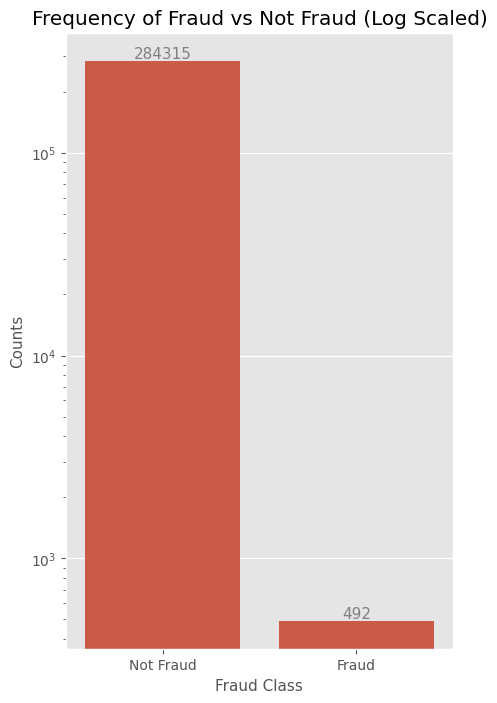

In [11]:
## Plot the number of occurences of each class with a bar chart and log-transformed y-axis ##

# Set the size of the plot figure (width, height)
plt.figure(figsize=(5, 8))  

# Create a count plot (bar plot in seaborn) to visualize the distribution of the 'Class' column (Fraud vs Not Fraud)
ax = sns.countplot(x='Class', data=fraud_df)

# Set the title and axes labels
plt.title('Frequency of Fraud vs Not Fraud (Log Scaled)')
plt.xlabel('Fraud Class', fontsize=11)
plt.ylabel('Counts', fontsize=11)

# Customize the x-axis ticks to denote labels 0 and 1 as 'Not Fraud' and 'Fraud' respectively
plt.xticks(ticks=[0, 1], labels=['Not Fraud', 'Fraud'], rotation=0)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Add count labels on top of the bars, accounting for log scale
for p in ax.patches:
    # Get the height of the bar (which represents the count)
    count = int(p.get_height())
    
    # Log scale may display very large or small values, so directly show the raw count
    ax.annotate(f'{count}',  # Display the count value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position label at the center of each bar
                ha='center', va='center', fontsize=11, color = 'gray',  # Center align and set font size & color
                xytext=(0, 5),  # Add a small vertical offset to prevent overlap
                textcoords='offset points')

# Display the plot
plt.show()


Evidently, the dataset is highly imbalanced. This is probably because, in real-life, fraudulent credit card transactions do not occur as often. As such, fraudulent credit card transactions comprise of a very small portion of total credit card transactions. <br>

With this consideration, two of the measures taken to ensure an appropriate model training are as follows: 
1) F1-score is used as a performance metric to balance between the precision and recall (see [Section 3.2](#32-evaluation-metrics) for more details). 
2) Data balancing is experimented to see if it improves performance for classification models (seen in algorithms under [Section 4](#4-supervised-learning-classification)). 

#### 2.3.2 Transaction Amount

Next, the distribution of the `Amount` column is also explored

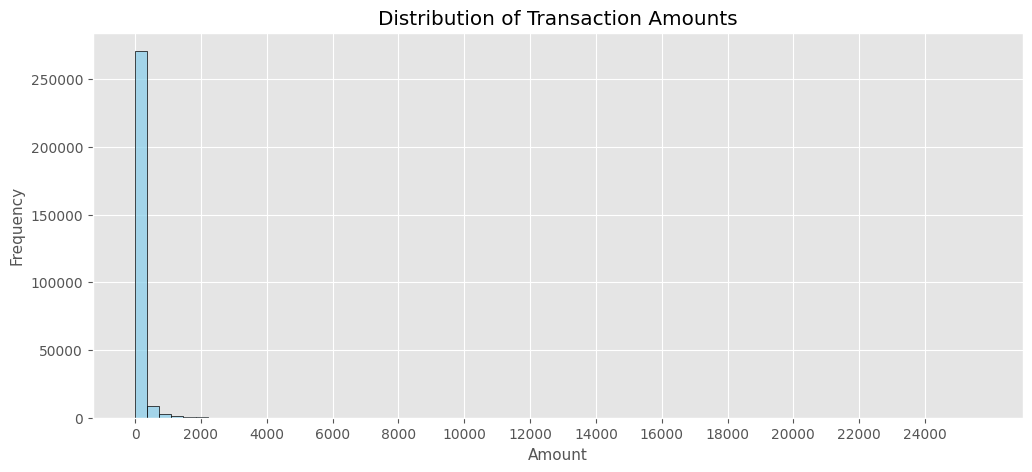

In [12]:
# Set size of the plot figure (width, height)
plt.figure(figsize=(12, 5))
# Create a hisotgram with the 'Amount' column and 70 bins (other aesthetic elements such as color and transparency are also specified)
sns.histplot(fraud_df['Amount'], bins = 70, color='skyblue', edgecolor='black', alpha=0.7) 

#Set the title and axes labels 
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount', fontsize=11)
plt.ylabel('Frequency', fontsize=11)

# Customize the x-axis ticks to be in multiples of 2000
plt.xticks(ticks=range(int(fraud_df['Amount'].min()), int(fraud_df['Amount'].max()), 2000))

# Display the plot
plt.show()


The majority of the transactions are very small. Once again, a log transformation on the y-axis can be used to view the bins more clearly. 

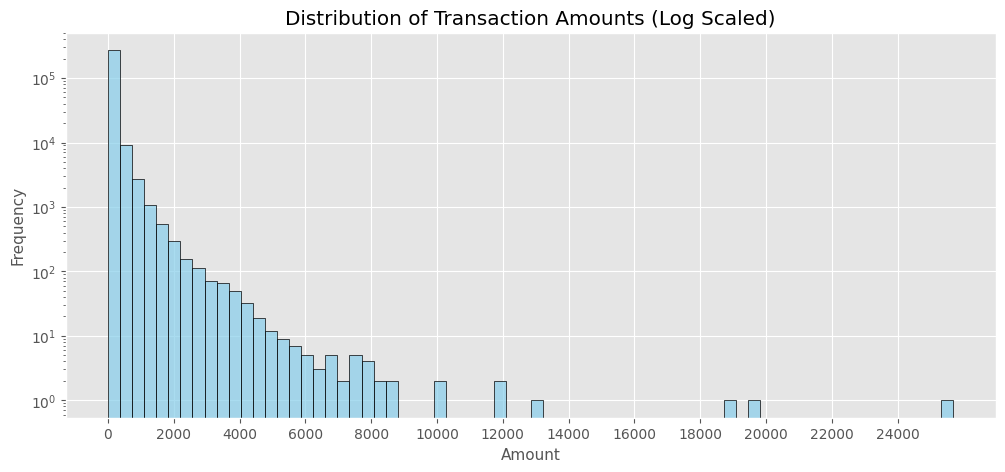

In [13]:
# Set size of the plot figure (width, height)
plt.figure(figsize=(12, 5))
# Create a hisotgram with the 'Amount' column and 70 bins (other aesthetic elements such as color and transparency are also specified)
sns.histplot(fraud_df['Amount'], bins=70, color='skyblue', edgecolor='black', alpha=0.7)

#Set the title and axes labels 
plt.title('Distribution of Transaction Amounts (Log Scaled)')
plt.xlabel('Amount', fontsize=11)
plt.ylabel('Frequency', fontsize=11)

# Customize the x-axis ticks to be in multiples of 2000, bounded by the minimum and maximum 'Amount' values
plt.xticks(ticks=range(int(fraud_df['Amount'].min()), int(fraud_df['Amount'].max()), 2000))

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Display the plot
plt.show()

Most of the transaction amounts are less than 500. (In Section 2.2.3 it was seen that 75% of the transactions were less than 77). There are some continuous bins that occur up to an amount of around 8500, after which the occurence of amounts larger than 10000 is very sparse. 

#### 2.3.3 Time

`Time` is another column that could be explored to find any potential patterns/trends in the affect of time in the transactions. Once again, a histogram is used to visualize the column. 

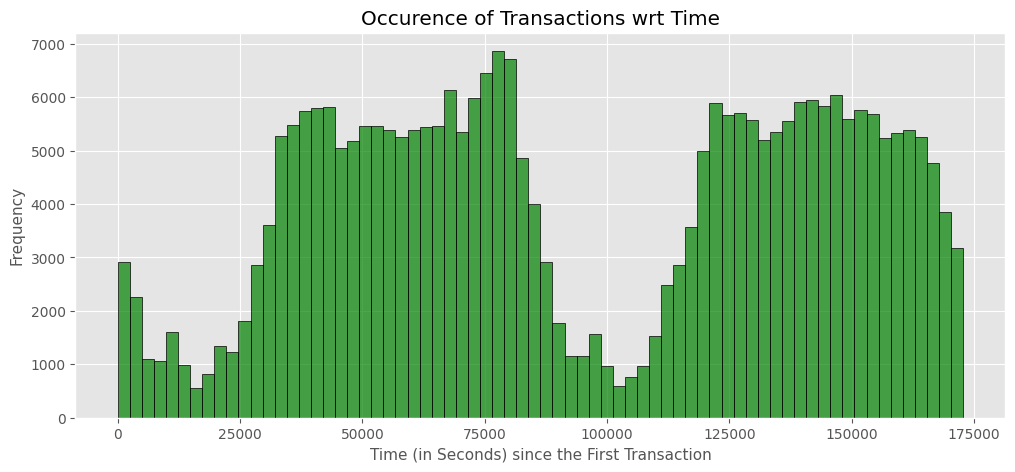

In [14]:
# Set size of the plot figure (width, height)
plt.figure(figsize=(12, 5))
# Create a histogram with the 'Time' column and 70 bins (other aesthetic elements such as color and transparency are also specified)
sns.histplot(fraud_df['Time'], bins=70, color='green', edgecolor='black', alpha=0.7)

#Set the title and axes labels 
plt.title('Occurence of Transactions wrt Time')
plt.xlabel('Time (in Seconds) since the First Transaction', fontsize=11)
plt.ylabel('Frequency', fontsize=11)

# Display the plot
plt.show()

The distribution of transactions seems to be bimodal, with dips occuring at around 20,000 seconds and 100,000 seconds.

Visualizing occurence as seconds can be less intuitive when the the number of seconds are in tens/hundreds of thousands. Let's plot these values in hours instead of seconds. 

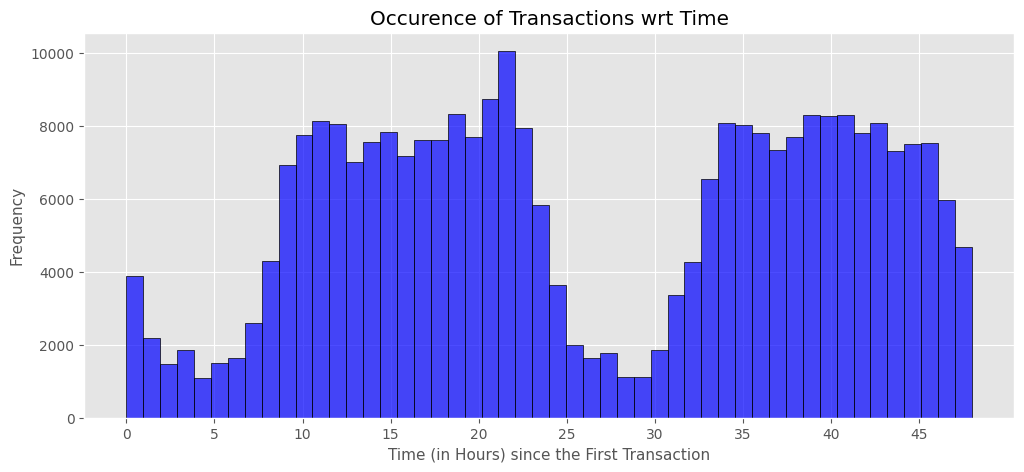

In [15]:
# Set size of the plot figure (width, height)
plt.figure(figsize=(12, 5))
# Create a hisotgram with the 'Time' column; here we have divided the values in the 'Time' column by 3600 (using the conversion rate of 1 hour = 3600 seconds)
sns.histplot(fraud_df['Time']/3600, bins=50, color='blue', edgecolor='black', alpha=0.7)

# Set the title and axes labels
plt.title('Occurence of Transactions wrt Time')
plt.xlabel('Time (in Hours) since the First Transaction', fontsize=11)
plt.ylabel('Frequency', fontsize=11)

# Customize the x-axis ticks to be in intervals of 5 hours, bounded by the minimum and maximum hours in the `Time` column
plt.xticks(ticks=range(int((fraud_df['Time']/3600).min()), int((fraud_df['Time']/3600).max()), 5))

#Display the plot
plt.show()

Plotting the transaction distribution over time in hours provides a much clearer view. The data reveals that the transactions span a period of approximately two days. Notably, there are dips in the activity at around 0-8 hours and 25-32 hours, which likely correspond to nighttime hours.

While the exact starting time of the first transaction is not given, the timings possibly reflect the different hours of the day and different activity levels expected. In particular, the 0-8 hour and 25-32 hour periods could possibly be representing the early morning hours (around 12AM-8AM on both days) when most people are typically asleep. The peak of activity likely occurs during the daytime, when people are generally awake and more active

#### 2.3.4 PCA Features 

The remaining columns that haven't been visualized yet are the PCA feature columns `V1` to `V28`. A histogram is also used to visualize these columns. Since these columns are similar in nature, they are plotted together on the same graph, each column separated into subplots. 

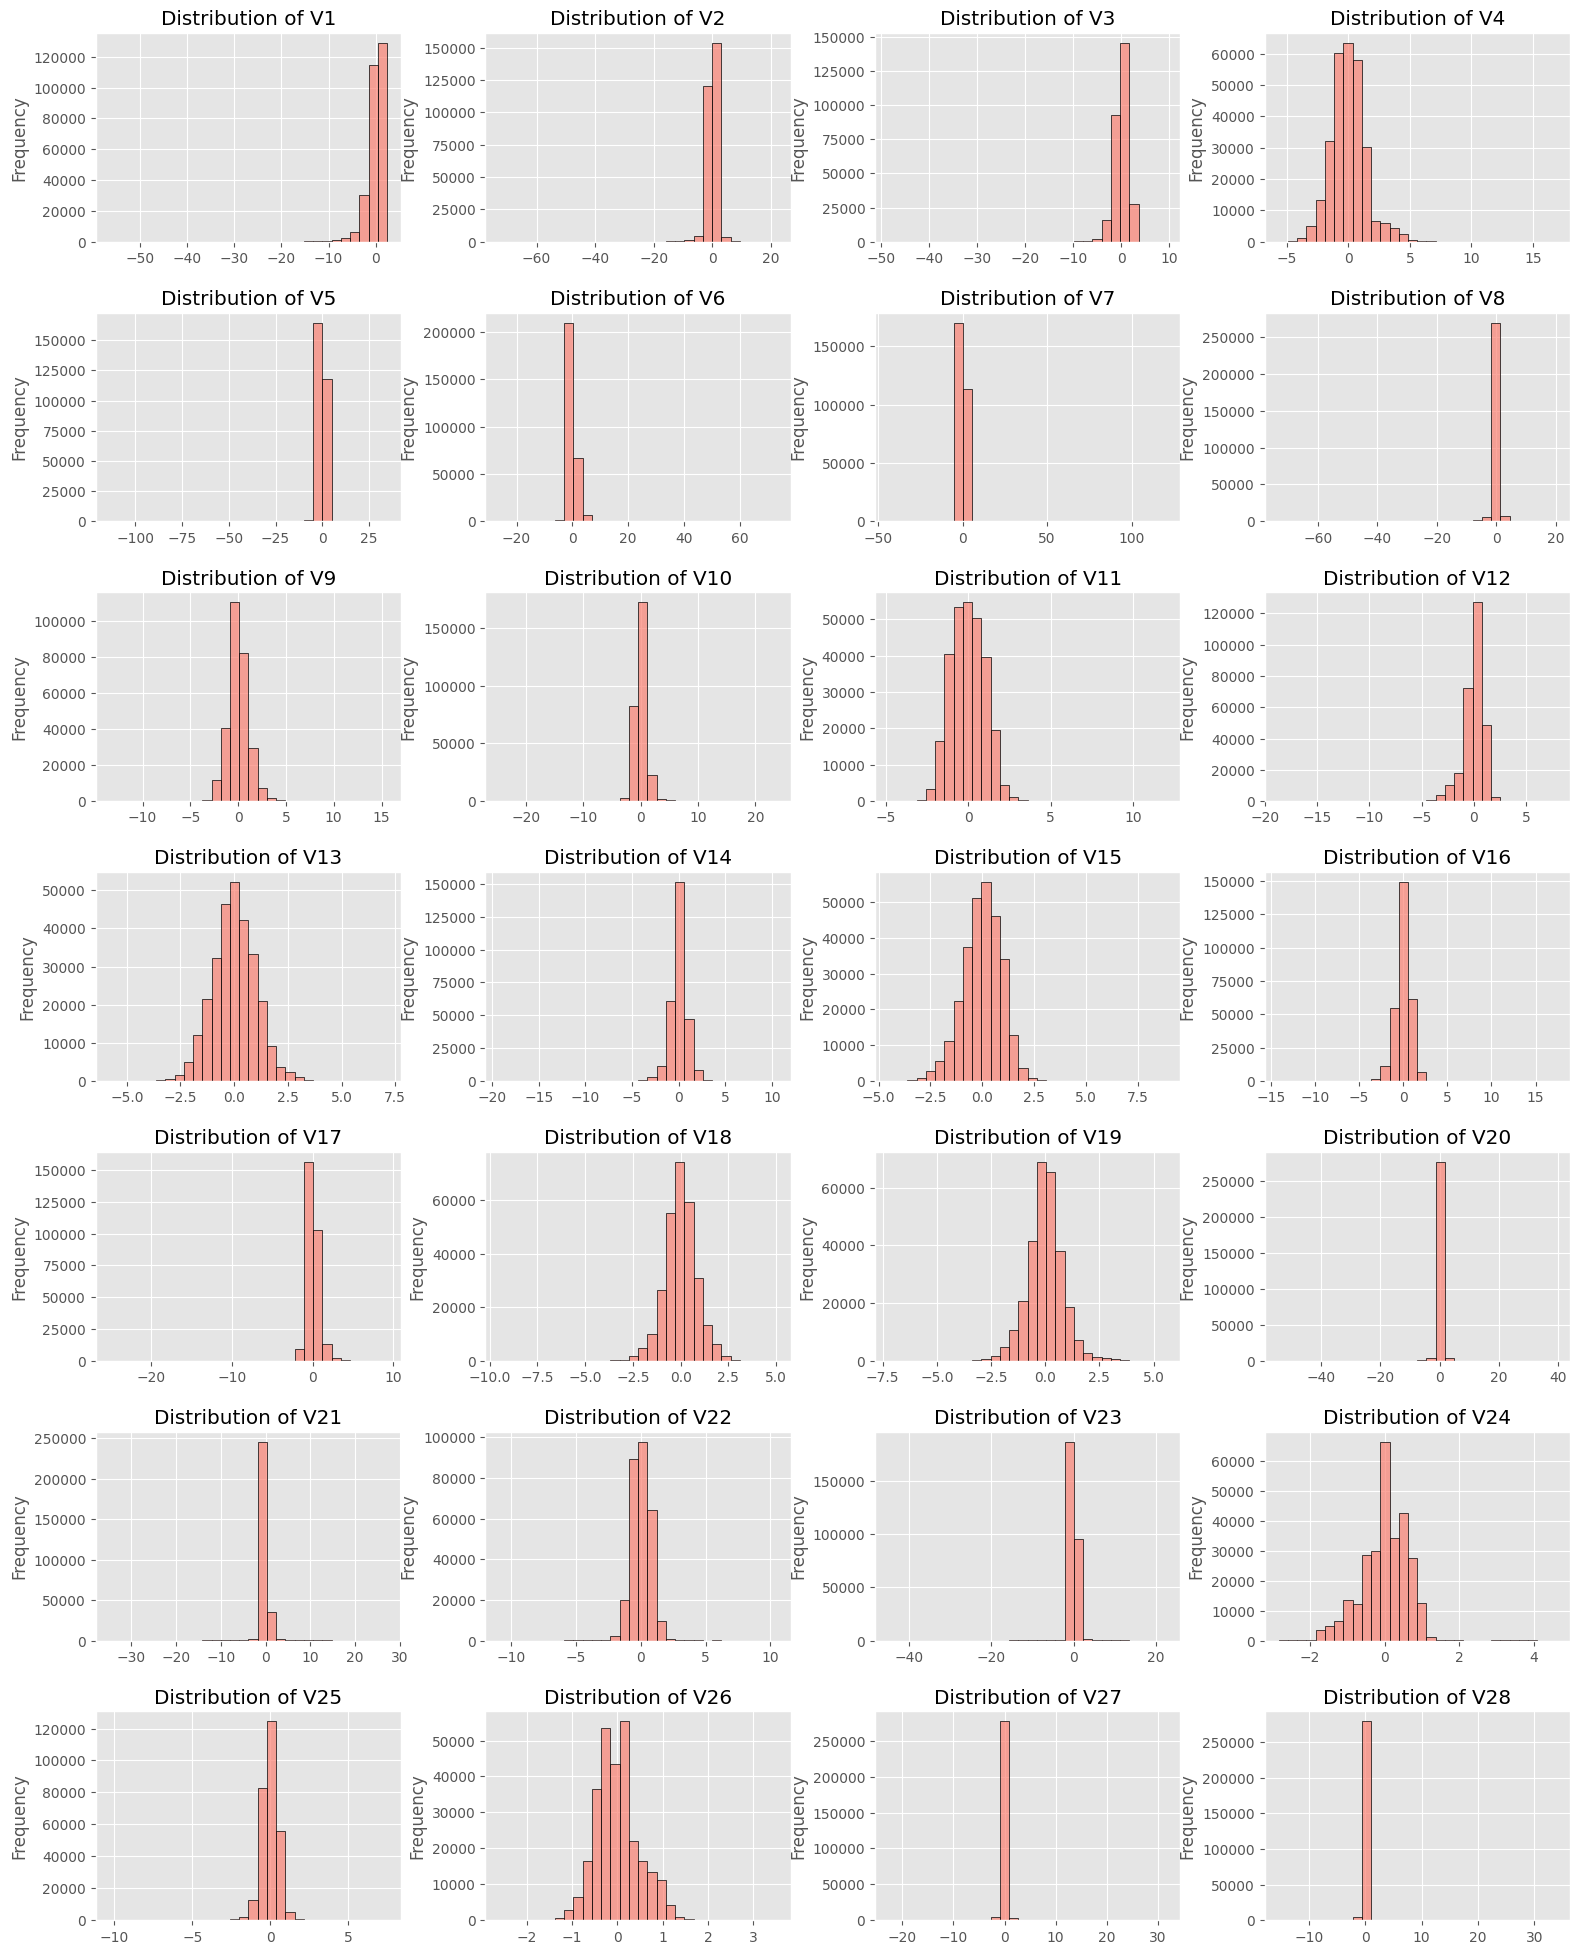

In [16]:
# List of columns to plot 
columns = [f'V{i}' for i in range(1, 29)] # a list of strings from V1 to V28

# Set up the subplot grid
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(16, 20))  # 7 rows, 4 columns for 28 plots
fig.tight_layout(pad=3.0)

# Flatten the axes array for easy indexing in the loop
axes = axes.flatten()

# Loop through each column and create a histogram in its own subplot
for i, col in enumerate(columns):
    # Create a histogram (bins 30 + other aesthetic specifications)
    sns.histplot(fraud_df[col], ax=axes[i], bins=30, color='salmon', edgecolor='black', alpha=0.7)

    # Set the title and axes labels in each subplot 
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

# Display the plot
plt.show()


Some observations we can note: 
- All of the above columns are centered around 0. 
- However, every column has different range of values. For example, `V24` and `V26` have range of values as small as around [-2, 4] while other columns like `V2` and `V8` have range of values in [-60, 20] or even `V5` with values from [-100, 25]. Thus, while all the columns are roughly centered around the same value, they have varying levels of standard deviation. 
**Solution**: Some of the algorithms used (e.g. clustering or SVM) are sensitive to scaling since they make use of distance metrics. As such, standardization to input data will be applied to the model pipeline (seen in [Section 4.3](#43-support-vector-machine-svm) and all of [Section 5](#5-unsupervisedsemi-supervised-learning-anomaly-detection)). 

- Some columns such as `V5`, `V8` and `V12` are skewed. The algorithms we will be testing out do not require any assumptions on the data distributions (i.e. no normality assumptions). As such, we will not be performing any transformations (like log transformations) on the input data. 

For the purposes of visualization, the the x-axis can be standard across the subplots ot have the same range of minimum and maximum values. This would make it easier to compare the distributions of each columns in terms of their range, skewness, etc. As before, we can also perform log transformation to both the axes for more clarity. 

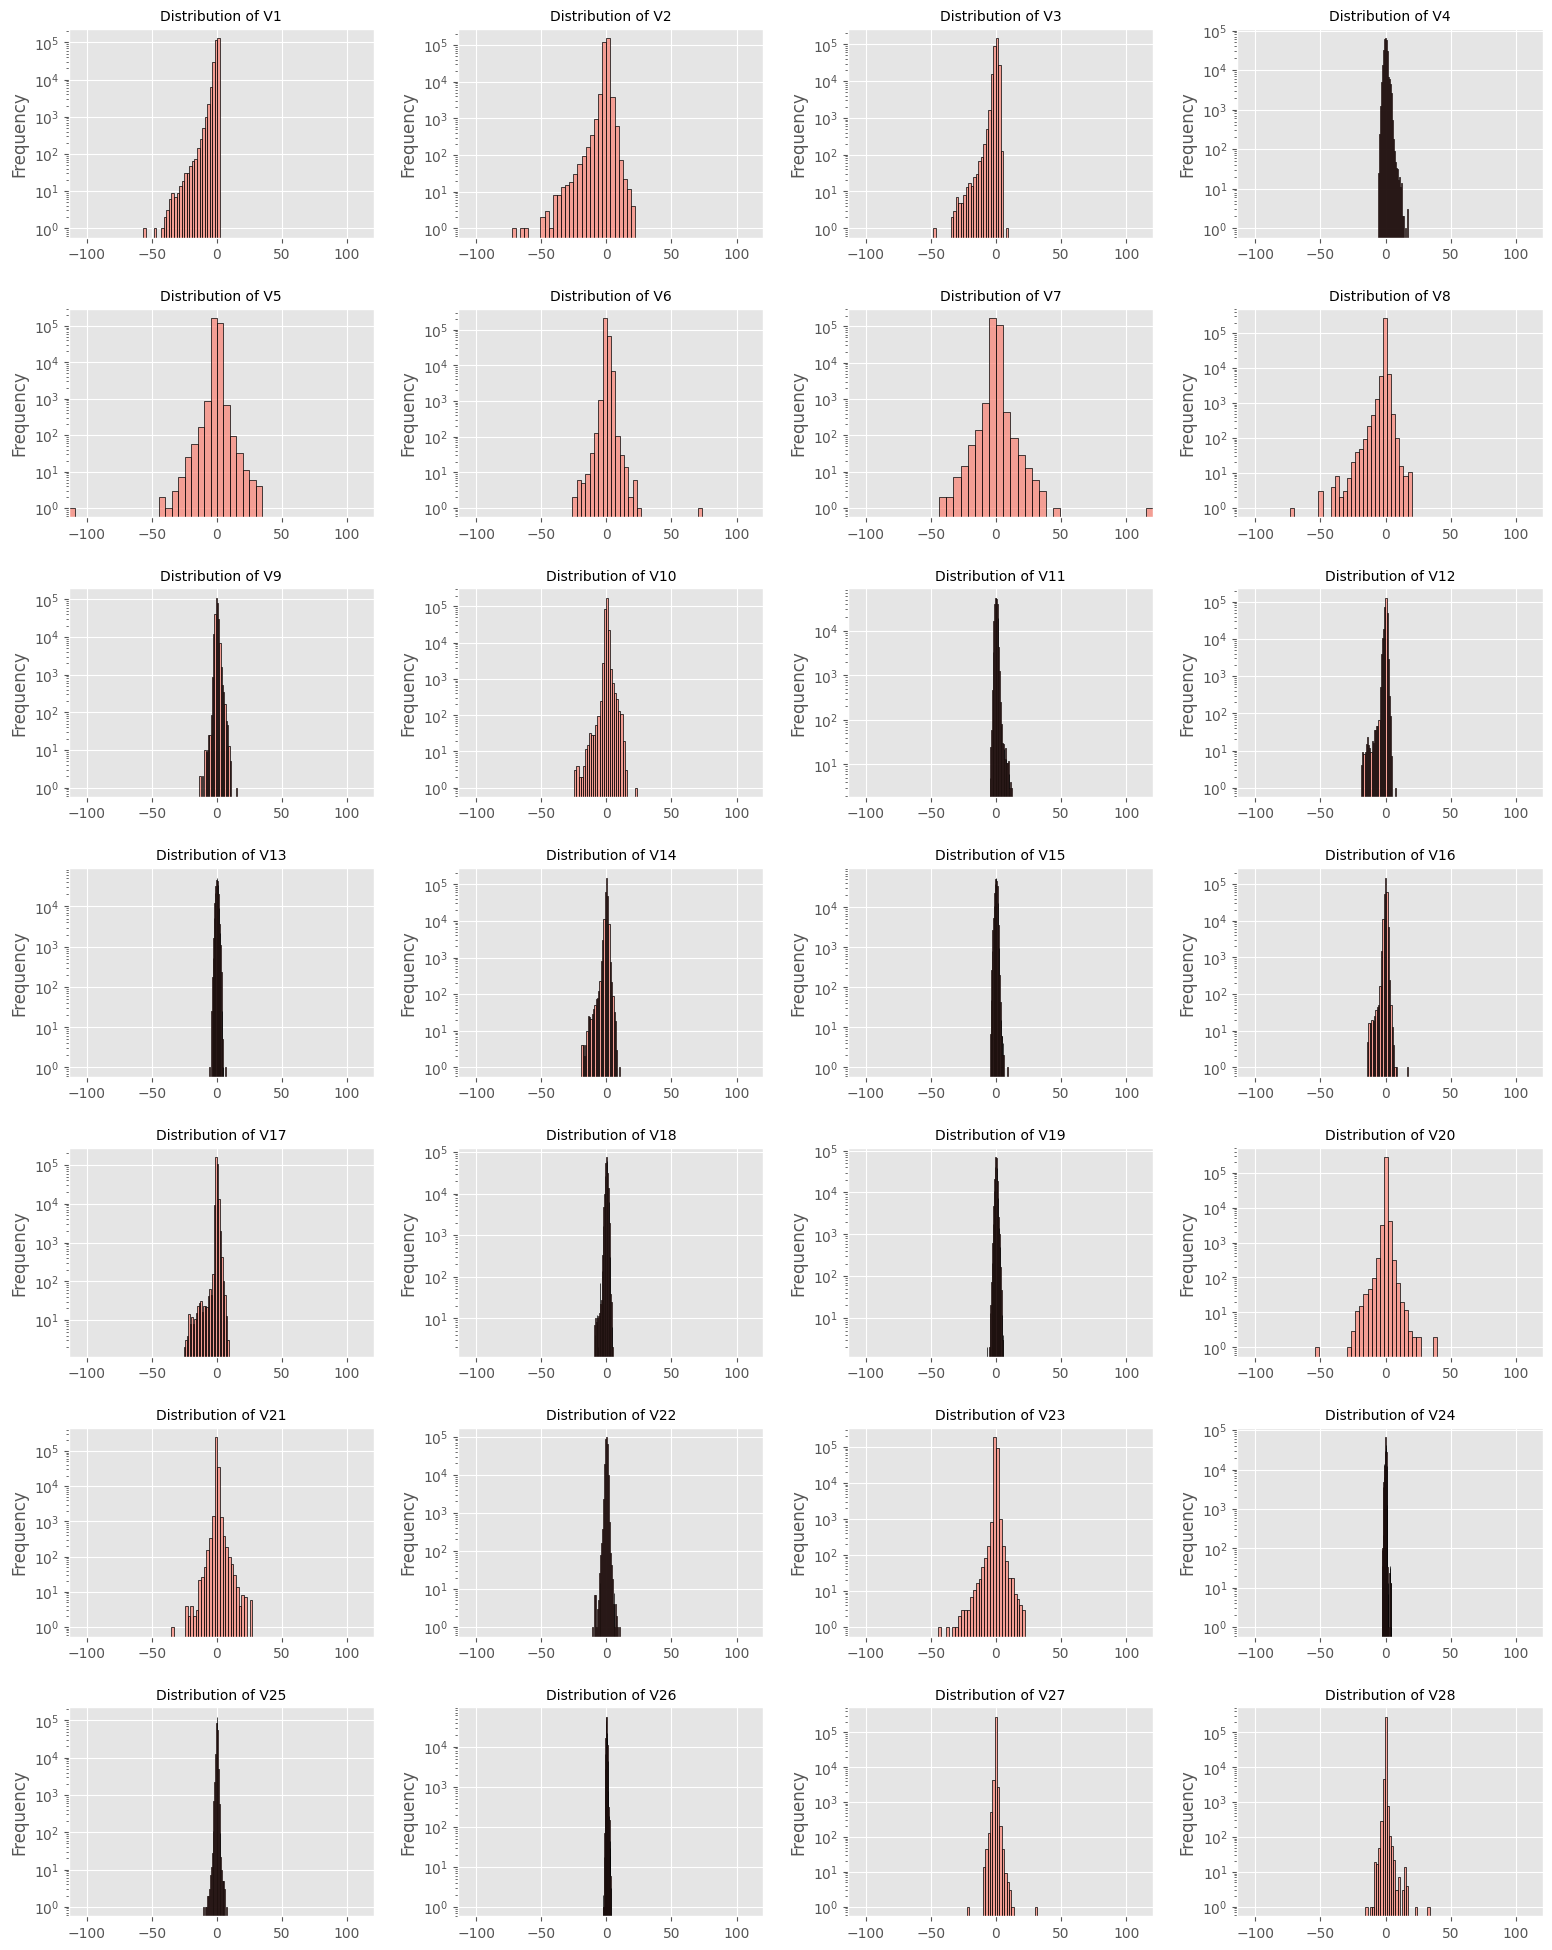

In [17]:
# List of columns to plot
columns = [f'V{i}' for i in range(1, 29)]

# Set up the subplot grid
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(16, 20))  # 7 rows, 4 columns for 28 plots
fig.tight_layout(pad=3.0)

# Flatten the axes array for easy indexing in the loop
axes = axes.flatten()

# Get the global min and max across all columns for standardized x-axis
global_min = fraud_df[columns].min().min()  # minimum of all columns
global_max = fraud_df[columns].max().max()  # maximum of all columns

# Loop through each column and create a histogram in its own subplot
for i, col in enumerate(columns):
    # Create a histogram (bins 30 + other aesthetic specifications)
    sns.histplot(fraud_df[col], ax=axes[i], bins=30, color='salmon', edgecolor='black', alpha=0.7)

     # Set the title and axes labels in each subplot 
    axes[i].set_title(f'Distribution of {col}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

    # Set x-axis limits based on global min and max
    axes[i].set_xlim(global_min, global_max) 
    # Apply log scale to the y-axis
    axes[i].set_yscale('log')

# Display the plot
plt.show()


## 3. Data Preparation 

### 3.1 Train-Test Splitting

Now we have completed the data exploration, we proceed to the model training stage. To prepare our data for training, the dataset is split into the following sets: 
1. Training Set (80%) - this will be used for the training process and performing cross validation (i.e the folds are obtained using this set only)
2. Test Set (20%) - this is used to evaluate the model's final performance (these metrics will be used to compare the performance across different algorithms)

In [18]:
# Separate the dataset into X (the input data) and y (the labels) 
# In this case, y is the 'Class' column while X is all of the other columns 
X = fraud_df.drop(columns=['Class'])
y = fraud_df['Class']

In [19]:
# Take 80% of the dataset for traing and keep the remaining 20% for testing
# Ensure the rows are shuffled before sampling and set a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=37) 

The folds for cross validation purposes are also created. 
Using 4-folds on the above training set means the validation set in every fold will be 20% of the original dataset's size

In [20]:
# Set up KFold with a random seed
folds = KFold(n_splits=4, shuffle=True, random_state=37) 

Check the sizes of training and testing sets as well as the proportion of fraudulent transactions in each of them. 

In [21]:
# Training Set 
print('Training Data Points: ', len(X_train))
print('Proportion of positives (frauds) in training set: ', y_train.mean())   #since the values in the y_column are just 0s and 1s, the mean = proportion of 1s
print('Testing Data Points: ', len(X_test))
print('Proportion of positives (frauds) in testing set: ', y_test.mean())

# Remark: the y sets can also be used for checking the number of data points  

Training Data Points:  227845
Proportion of positives (frauds) in training set:  0.0017336347078057452
Testing Data Points:  56962
Proportion of positives (frauds) in testing set:  0.0017028896457287315


The size of the two sets are all correct as per our desired split. The proportion of positives (i.e. the number of frauds) are also roughly equal across them. 

### 3.2 Evaluation Metrics

As seen in [Section 2.3.1](#231-fraud-class), the dataset is imbalanced, which suggests that accuracy would be high even if the model does not classify data points in the minority class well. Even with a very small number of true positives (correctly classified fraudulent transactions), as long as number the number of true negatives (correctly classified normal transactions) is high, the accuracy of the model could be very high. 

In order to prevent the performance of majority class from being overrepresented, the  F1-score is used as the main metric to evaluate our model performance. 

F1-score is the harmonic mean of precision and recall. Recall provides the number of correctly predicted fraudulent transactions as a proportion of the total fraudulent transactions. Thus, a higher recall means the model correctly captures a high proportion of fraudulent transactions. Meanwhile, precision provides the number of correctly predicted fraudulent transactions as a proportion of the total transactions that were predicted to be fraudulent. Thus, a higher precision means the model does not wrongly flag a lot of normal transactions as fraudulent. 

On one hand, a model with low recall and high precision would not be useful since many fraudulent transactions would go undetected. On the other hand, a model with high recall and low precision would be impractical as it would lead to high costs and significant inconvenient for consumers whose transactions were indeed normal. Hence, 
F1-score balances the trade-off between capturing fraudulent transactions while also minimizing incorrect classification of normal transactions as fraudulent. (for more details see report)

The following custom Python function is used to evaluate our models in [Sections 4](#4-supervised-learning-classification) and [5](#5-unsupervisedsemi-supervised-learning-anomaly-detection). The custom function not only includes the F1-score, but also lists the recall, precision, and plots a confusion matrix. A confusion matrix is a table that displays the number oftrue positives, true negatives, false positives, and false negatives. 

In [22]:
def eval_model(pred_vals, true_vals):
    """
    Evaluate the model performance by calculating recall, precision, F1-score, and confusion matrix.

    Parameters:
    pred_vals (array-like): The predicted values (model's predictions).
    true_vals (array-like): The true ground truth values. 

    Prints:
    - Precision
    - Recall
    - F1-score
    - Confusion Matrix
    """
    # Calculate Precision, Recall, and F1-score
    precision = precision_score(true_vals, pred_vals)
    recall = recall_score(true_vals, pred_vals)
    f1 = f1_score(true_vals, pred_vals)

    # Calculate Confusion Matrix
    conf_matrix = confusion_matrix(true_vals, pred_vals)

    # Print the metrics
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")

    # Plot the Confusion Matrix
    plt.figure(figsize=(4, 4))
    #ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True, xticklabels= ['Normal','Fraud'], cmap = 'crest',
                      yticklabels = ['Normal','Fraud'], fmt="d", vmin=0, vmax=conf_matrix.max())
    plt.xlabel('Predicted')
    plt.ylabel('Actual') 

    plt.show()

The following function is also very similar, except that it only returns the precision, recall, and f1 scores as a tuple. This is used at the end for summarizing all the explored models in Sections 4 and 5. 

In [23]:
def eval_model_summary(pred_vals, true_vals):
    """
    Evaluate the model performance by calculating recall, precision, F1-score, and confusion matrix.

    Parameters:
    pred_vals (array-like): The predicted values (model's predictions).
    true_vals (array-like): The true ground truth values. 

    Returns:
    - F1-Score
    - Precision
    - Recall
    """
    # Calculate Precision, Recall, and F1-score
    precision = precision_score(true_vals, pred_vals)
    recall = recall_score(true_vals, pred_vals)
    f1 = f1_score(true_vals, pred_vals)

    return f1, precision, recall

In [24]:
# The following dictionary is created to store the predicted values of different models
all_y_preds = {}

## 4. Supervised Learning (Classification)

In the Section 4, the credit card fraud detection problem is viewed as a supervised learning, classification problem, where given a data point (transaction), the model classifies it as a 0 (normal) or 1 (fraudulent). 

The algorithms explored in this section are: 
- 4.1: Logistic Regression 
- 4.2: Decision Tree 
- 4.2 (extension): Ensembling of Trees
- 4.3: Support Vector Machine

For each of the above algorithms, the following steps are performed: <br>
> a) Fit a base model (with default model parameters) <br>
> b) Conduct hyperparameter tuning via cross validation on the training set (implemented via [scikit-learn's GridSearchCV](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html)) <br>
> c) Fit an optimized model based on b) and obtain a final test score on the testing set <br>
> d) Repeat steps b) and c) with data balancing (prior to model training).

**Some remarks on the data balancing:**
A high imbalance in classes could potentially cause classification models to favor the majority class, or simply learn the patterns in the majority class more robustly as compared to the minority class. This is undesirable in the context of fraud detection, where identifying frauds (the minority class) is the main goal. As such, data balancing methods are also explored to see if they show any improvement in model performance. 



With this consideration, two data balancing approaches are considered for classification algorithms in this section: 
1. **Undersampling**: A random sub-sample of the majority class is taken to match the count of the minority class. [Imbalanced-learn's RandomUnderSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) class is chosen for this notebook, which utilizies K-means to undersample the majority class. <br>
*Pro:* Undersampling reduces risk of overfitting <br>
*Con:* Undersmapling potentially leads to the loss of important information in the minority class <br>

2. **Oversampling**: The number of data points in the minority class is randomly sample and augmented to the data until the count of the minority class matches that of the majority class. In this notebook, SMOTE (Synthetic Minority Over-sampling Technique) ([Chawla, 2002](https://doi.org/10.1613/jair.953)) is used based on [Imbalanced-learn's implementation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Simply du0plicating existing samples from the minority does not add much value to the data. SMOTE improves on this creating synthetic samples of the minority class based on the existing points seen in the minority class. A synthetic sample is created by combing an existing data point with its nearest neighbor to create a new data point. <br>
*Pro:* Oversampling retains data information. <br>
*Con:* Oversampling could add more noise to the data (which may make the model more prone to overfitting)

### 4.1 Logistic Regression 

The first classification algorithm experimented is Logistic Regression. Logistic Regression is a specialized of general linear basis model for binary classification tasks. Since this is a form of linear basis model, logistic regression has a linearity assumption.  

Referring to the classification linear models learnt in class, the linear basis function is passed to a non-linear activation function. In the case of Logistic Regression, the activation function used is a sigmoid, which outputs a scalar in the range of [0,1], representing a probability that the output is of class = 1. 

#### 4.1.a) Base Model 

First a base model is fitted. By default, it uses a L2 regularization with regularization parameter = 1 ([Logistic Regression from Scikit-Learn)](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)). 

In [25]:
# Create and train a Logistic Regression classifier 
log_reg_clf = LogisticRegression()

# Train the clasifier 
log_reg_clf.fit(X_train, y_train)

/Users/sneha/Documents/Sneha/Academic_Learning/NUS_Masters/DSA5105/Project/dsa5105_proj/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

The Logistic Regression model could not converge with the default parameter and we are suggested to either increase the number of iterations or scale the data. Although typically logistic regression does not require scaling, let us try to add a scaler to the model pipeline and try again. 

The [StandardScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html) used from scikit-learn scales the values to a zero norm and unit variance. 

The [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class is used to create a model using multiple scikit-learn's model classes. 


In [26]:
# Create and train a Logistic Regression classifier 
log_reg_clf = Pipeline([
     ('scaler', StandardScaler()),        # Step 1: Scale features to zero norm and unit variance
     ('log_reg', LogisticRegression())    # Step 2: Apply Logistic Regression 
 ])

# Train the clasifier 
log_reg_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression())])

It seems the scaler has solved the issue. 

#### 4.1.b) Finding Optimal Model Parameters

The logistic model is tuned on following parameters: 
- Penalty: no regularization, L1 or L2 regulatization 
- Regularization parameter values (C): 0.01, 0.1, 1, 10
- Maximum iteration (max_iter): the maximum number of iterations to for the solvers to converge 

A paramter grid is created using set of parameters to test 

In [27]:
# Define parameter grid for tuning
# note that that parameters are split into different dictionaries since None, L1, and L2 regularization penalty are all solved using different solvers (see the LogisticRegression documentation for details)
# splitting into different dictionaries ensures only the specified solver for that set of parameters is used (this avoids the model from running into errors)


# the paramter names need to be prefixed with "log_reg_" to specify which model in the pipeline do these paramters apply to
# the name of these prefix is determined by how we name each model in the pipeline. As seen below, the LogisticRegression model is chosen to be named as "log_reg"
param_grid_log = [
    # No regularization
    {'log_reg__penalty': [None],
     'log_reg__solver': ['lbfgs'],           #the default solver is used, which is compatable with no regularization or l2 regularization
     'log_reg__max_iter': [200, 500, 800]
     # there is no value of C specified since there is no regularization
    },

    # L1 regularization 
    {'log_reg__penalty': ['l1'],
     'log_reg__solver': ['liblinear'],        #liblinear solver is used, which is compatable with L1 regularization
     'log_reg__max_iter': [200, 500, 800],
     'log_reg__C': [0.1, 1, 10]
    },

    #L2 regularization
    {'log_reg__penalty': ['l2'],
     'log_reg__solver': ['lbfgs'],           #the default solver is used, which is compatable with no regularization or l2 regularization
     'log_reg__max_iter': [200, 500, 800],
     'log_reg__C': [0.1, 1, 10]
    }
]

After the paramter grid has been created, a grid search is implemented. GridSearchCV tests out every combination of the specified parameters and chooses the combination that gives the best cross validation score. 

In the below implementation, the following things are specified: 
- The logistic regression model itself (Note that the scaling is applied in the model pipeline instead of the entire training set. This ensures that instead of scaling the training set (i.e. both training and validation data in each fold) using the same transformation, the scaling is first applied only to the training data, and then used to transform the validation data. This way, there is no data leakage from the training data to validation data in each fold.)
- Parameter grid from previous step
- 4-folds created in [Section 3.1](#31-train-test-splitting)
- CV score is calculated by averaging F1-score in each of the 4 folds
- Verbose = 3 is to simply have print statements show the CV process (scores on each efold and the time taken)

*The following grid search has been commented out since it takes too long. The saved state can be loaded.*

In [28]:
# # Run GridSearch with cross-validation

# log_grid = GridSearchCV(Pipeline(          # MODEL #
#     [('scaler', StandardScaler()),         # Step 1: Scale features to zero norm and unit variance
#      ('log_reg', LogisticRegression())]    # Step 2: Apply Logistic Regression
# ), 
#                         param_grid_log, cv=folds, scoring = 'f1', verbose = 3)


# log_grid.fit(X_train, y_train)

*The above code for running the grid search has been commented as it takes around 10 minutes to run. The saved grid search object can be directly loaded into the environment using the following code.*

In [29]:
# Load results -- make sure edit the file path to where the pkl file has been saved
log_grid = joblib.load('./saved_objects/logistic_reg_param_search.pkl')     #ensure to adjust the file path according to where the pkl file is saved in your local directory

The best parameters and scores can be viewed as follows

In [30]:
# Best parameters and score
print(f"Best Parameters: {log_grid.best_params_}")
print(f"Best F1 Score: {log_grid.best_score_:.4f}")

Best Parameters: {'log_reg__C': 10, 'log_reg__max_iter': 200, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}
Best F1 Score: 0.7122


Using a L2 regularization with a regularization parameter of 10 is found to produce the best model. The maximum number of iterations is also best to be at 200. 

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [31]:
# # Save results 
# joblib.dump(log_grid, './saved_objects/logistic_reg_param_search.pkl')     

#### 4.1c) Fit and Test Model with Optimal Parameters

The Logistic Regression model with optimized parameters is now tested on the testing set.

Note that with GridSearchCV, it is not required to recreate the model with the paramters. Instead, the object can be directly used as a model to make predictions. By default, it will use the best model found to make the predictions. 

Precision: 0.889
Recall: 0.577
F1-score: 0.700


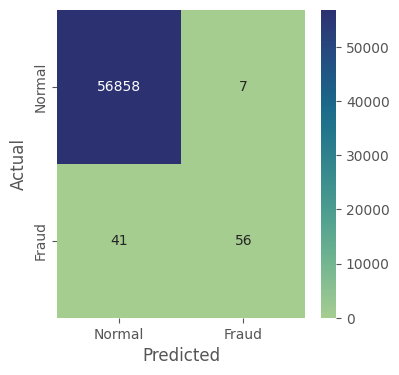

In [32]:
# Obtain the predicted values
y_predicted_log_reg_tuned = log_grid.predict(X_test)

#Evaluate the model
eval_model(y_predicted_log_reg_tuned, y_test)

The performance of the model is decent. It does well in classifying the normal transactions, but not so well in capturing fraudulent transactions.

In [33]:
# Save for future reference (results summary)
all_y_preds['Logistic Regression'] = y_predicted_log_reg_tuned

#### 4.1d) With Data Balancing 

Now, the same procedure as part b) is experimented with data balancing methods. Just like scaling, the undersampling/downsampling is also applied in the model pipeline itself, instead of the entire training set. This ensures the data balancing is only applied to the training data in each fold and the validation data remains as it is. 

Data balancing is applied before scaling since data balancing does not transform data and works on the assumption that all variables are in their original scale. 

The same paramter grid used for hyperparameter tuning in part b) is also used here.

**Undersampling**

*The following grid search has been commented out since it takes too long. The saved state can be loaded.*

In [34]:
# # Run GridSearch with cross-validation
# log_grid_u = GridSearchCV(ImbPipeline([       #scikit-learn's pipeline does not support objects from imbalanced-learn, so the pipeline from imbalanced-learn is used here
#     ('undersampling', RandomUnderSampler(random_state = 37)),
#     ('scaled', StandardScaler()), 
#     ('log_reg', LogisticRegression())
# ]), 
#         param_grid_log, cv=folds, scoring = 'f1', verbose = 3)

# log_grid_u.fit(X_train, y_train)

In [35]:
# Load the model -- make sure edit the file path to where the pkl file has been saved
log_grid_u = joblib.load('./saved_objects/logistic_reg_undersampling_param_search.pkl')

In [36]:
# Best parameters and score
print(f"Best Parameters: {log_grid_u.best_params_}")
print(f"Best F1 Score: {log_grid_u.best_score_:.4f}")

Best Parameters: {'log_reg__C': 0.1, 'log_reg__max_iter': 500, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
Best F1 Score: 0.2203


The optimized model paramters are quite different after using undersampling. The best paramters use l1 regularization with regularization paramter of 0.1. More iteration with max_iter of 500 also produce better results.

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [37]:
# # Save the model to a file
# joblib.dump(log_grid_u, './saved_objects/logistic_reg_undersampling_param_search.pkl')

Precision: 0.090
Recall: 0.918
F1-score: 0.164


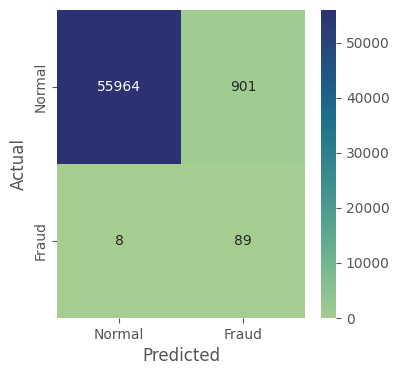

In [38]:
# Obtain the predicted values 
y_predicted_log_reg_bal_u = log_grid_u.predict(X_test)

#Evaluate the model
eval_model(y_predicted_log_reg_bal_u, y_test)

**Oversampling**

*The following grid search has been commented out since it takes too long. The saved state can be loaded.*

In [39]:
# # Run GridSearch with cross-validation
# log_grid_o = GridSearchCV(ImbPipeline([
#     ('oversampling', SMOTE(sampling_strategy = 'minority', random_state = 37)),
#     ('scaled', StandardScaler()), 
#     ('log_reg', LogisticRegression())  #default uses a RBF kernel
# ]), 
#         param_grid_log, cv=folds, scoring = 'f1', verbose = 3)

# log_grid_o.fit(X_train, y_train)

In [40]:
# Load the model -- make sure edit the file path to where the pkl file has been saved
log_grid_o = joblib.load('./saved_objects/logistic_reg_oversampling_param_search.pkl')

In [41]:
# Best parameters and score
print(f"Best Parameters: {log_grid_o.best_params_}")
print(f"Best F1 Score: {log_grid_o.best_score_:.4f}")

Best Parameters: {'log_reg__C': 10, 'log_reg__max_iter': 200, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}
Best F1 Score: 0.2550


The optimized model paramters with oversampled data is exactly same as the optimized paramters for data with no balancing.

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [42]:
# # Save the model to a file
# joblib.dump(log_grid_o, './saved_objects/logistic_reg_oversampling_param_search.pkl')

Precision: 0.152
Recall: 0.918
F1-score: 0.260


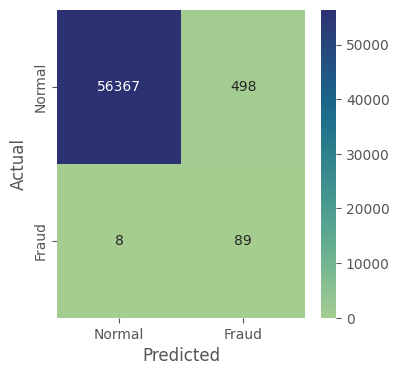

In [43]:
# Obtain the predicted values 
y_predicted_log_reg_bal_o = log_grid_o.predict(X_test)

eval_model(y_predicted_log_reg_bal_o, y_test)

Both data balancing methods show a significant improvement in the recall score, meaning that it is much better at capturing fraudulent transactions. However, it also comes at significant cost of lower precision, meaning that the model also wrongly classifies many normal transactions as fraudulent. Balancing between the two metrics, the F1-score dropped with data balancing methods. 

*Remark: We can hypothesize from the above that data balancing does not improve model performance. However, for the sake of demonstration, the data balancing experiments for other classification algorithms have also been kept. As seen later, data balancing in other classification algorithms also indeed show a similar test result, with worsened F1-score.*

In [44]:
# Save for future reference (results summary)
all_y_preds['Logistic Regression (Undersampling)'] = y_predicted_log_reg_bal_u
all_y_preds['Logistic Regression (Oversampling)'] = y_predicted_log_reg_bal_u

### 4.2 Decision Tree

The next classification algorithm explored is decision trees. As seen in class, decision tree is a tree-based algorithm that recursively splits the data in the feature space into different regions to make predictions.

#### 4.2.a) Base Model

A baseline model is fitted first. [Scikit-learn's DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) is used with the default parameters. 

Note that decision tree has no linearity assumption, no use of distance-base methods, and no normality assumptions. As such, there is no need of any data pre-processing in the model pipeline. 

In [45]:
# Create and train a Decision Tree classifer
dt_clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier()

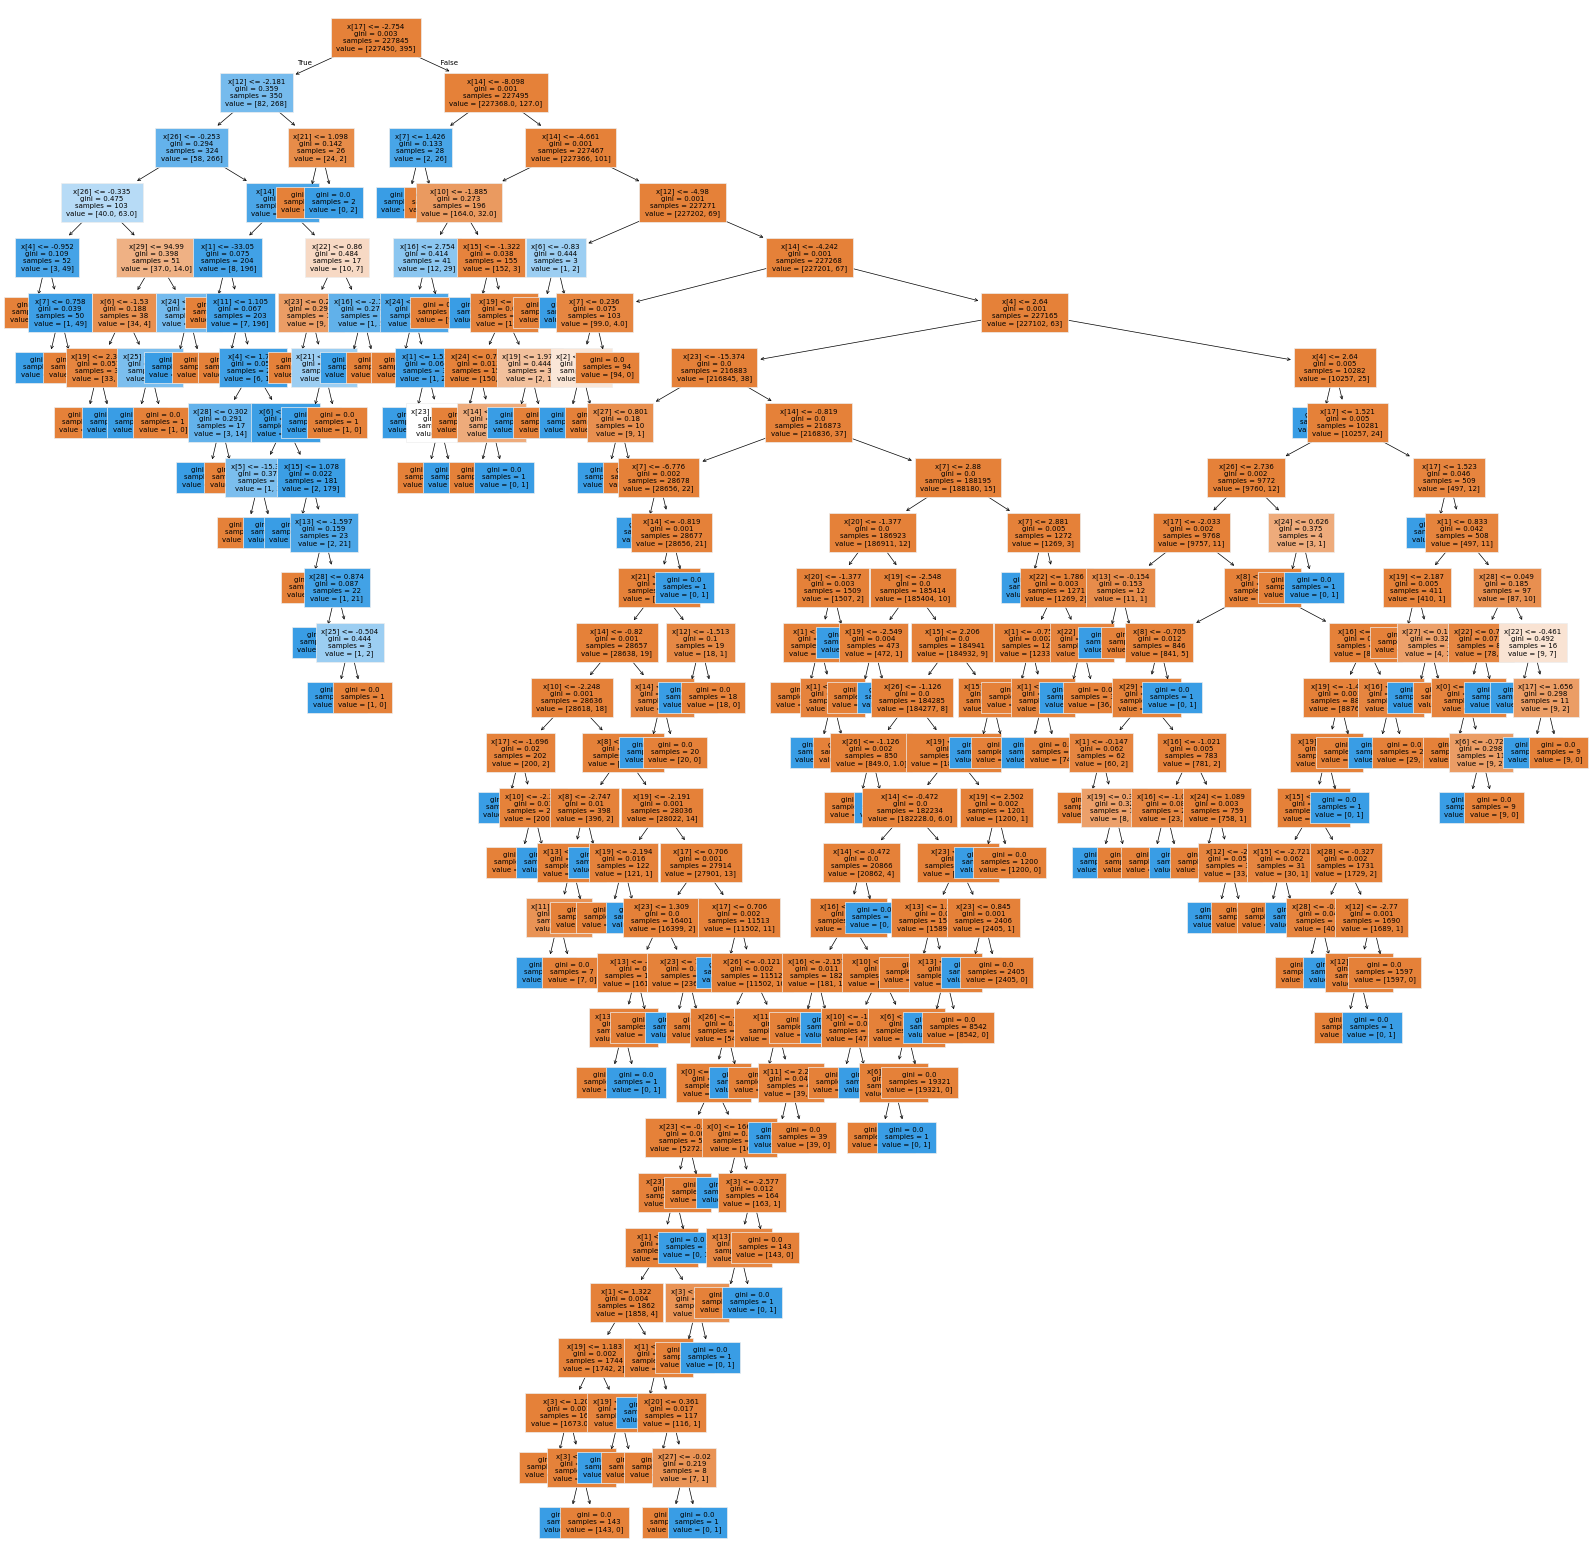

In [46]:
plt.figure(figsize=(20, 20))
plot_tree(dt_clf, 
          filled=True, # Fill nodes with colors
          fontsize = 5)           # Adjust font size
plt.show()

Evidently, the decision tree is very complex and the model is most likely overfitting to the data. This is expected given that we have a large dataset with a lot of features. This is also something that will be addressed in hyperparameter tuning

#### 4.2.b) Finding Optimal Model Parameters 

One of the major things we can do to mitigate overfitting is to limit the size of the decision tree. This can be experimented with the following parameters: 
- Max depth of the tree (max_depth)
- Maximum features to use for the splits (max_features)
- Minimum number of samples required to split an internal node

The hyperparameter tuning is similarly done as logistic regression, with a parameter grid followed by a grid search. 

Note that the default parameters (max_depth, max_features = None and min_samples = 2 are also included in the paramter grid)

In [47]:
# Define parameter grid for tuning
# note that there is no prefix required since there is no pipeline, only one DecisionTreeClassifier
param_grid_dt = {
    'max_depth': [None, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2'], 
    'min_samples_split': [2, 3, 4]
}

*The grid search takes around 2 minutes to run and has been commented out. The saved state can be loaded.*

In [48]:
# # Run GridSearch with cross-validation

# dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=folds, scoring = 'f1', verbose = 3)
# dt_grid.fit(X_train, y_train)

In [49]:
# Load the saved model from the file -- make sure edit the file path to where the pkl file has been saved
dt_grid = joblib.load('./saved_objects/decision_tree_param_search.pkl')

In [50]:
# Best parameters and score
print(f"Best Parameters: {dt_grid.best_params_}")
print(f"Best F1 Score: {dt_grid.best_score_:.4f}")

Best Parameters: {'max_depth': 6, 'max_features': None, 'min_samples_split': 4}
Best F1 Score: 0.8247


The optimal parameters are found to be a tree with depth 6 and no limit on the maximum number of features. The minimum samples to split in internal node is best at 4 samples. 

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [51]:
# # Save the model to a file
# joblib.dump(dt_grid, './saved_objects/decision_tree_param_search.pkl')

#### 4.2c) Fit and Test Model with Optimal Parameters

Performance on the optimized model is obtained in a similar manner

Precision: 0.897
Recall: 0.804
F1-score: 0.848


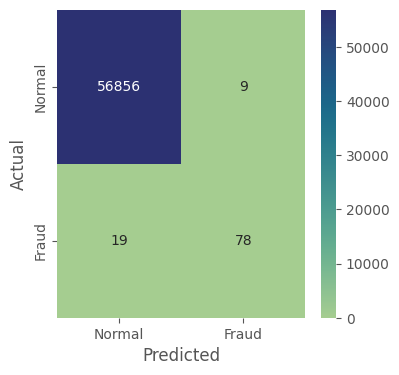

In [52]:
# Obtain the predicted values
y_predicted_dt_tuned = dt_grid.predict(X_test)

# Evaluate the model
eval_model(y_predicted_dt_tuned, y_test)

In [53]:
# Save for future reference (results summary)
all_y_preds['Decision Tree'] = y_predicted_dt_tuned

The model performance has improved on the test is better than what was seen in Logistic Regression. The new decision tree can also be visualized as below. 

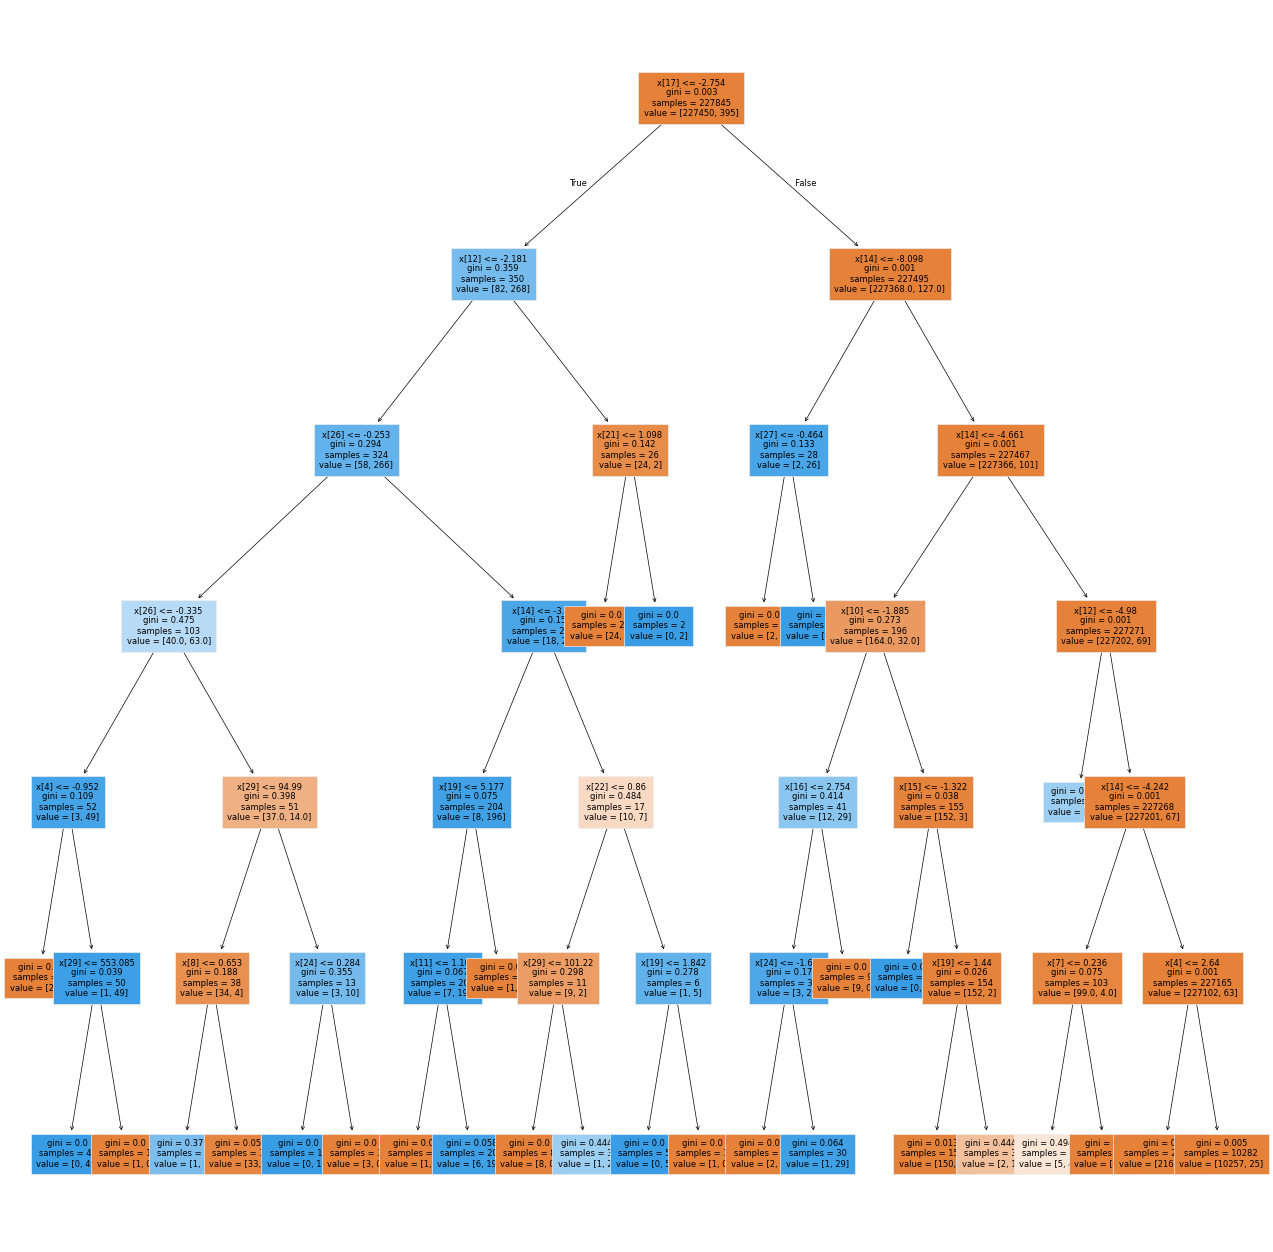

In [54]:
plt.figure(figsize=(16, 16))
plot_tree(dt_grid.best_estimator_,  #best estimator is used to retrieve the DecisionTreeClassifier object corresponding to the model with best parameters
          filled=True, # Fill nodes with colors
          fontsize = 6)           # Adjust font size
plt.show()

The decision tree is now less complex and more interpretable. 

#### 4.2.d) With Data Balancing

Let's see if data balancing helps the decision tree.

**Undersampling**

A new paramter grid is defined so that the dictionary keys may be appened with the model name. This is because a model pipeline with multiple objects is used with data balancing present. The paramters, however, still remain the same. 

In [55]:
# Define parameter grid for tuning
param_grid_dt = {
    'dt__max_depth': [None, 4, 6, 8, 10],
    'dt__max_features': [None, 'sqrt', 'log2'], 
    'dt__min_samples_split': [2, 3, 4]
}

*The following code has been commented out to avoid long run times. The saved state can be loaded.*

In [56]:
# # Run GridSearch with cross-validation
# dt_grid_u = GridSearchCV(ImbPipeline([                      #scikit-learn's pipeline does not support objects from imbalanced-learn, so the pipeline from imbalanced-learn is used here
#     ('undersampling', RandomUnderSampler(random_state = 37)),
#     ('dt', DecisionTreeClassifier())  #default uses a RBF kernel
# ]), 
#         param_grid_dt, cv=folds, scoring = 'f1', verbose = 3)

# dt_grid_u.fit(X_train, y_train)

In [57]:
# Load the model -- make sure edit the file path to where the pkl file has been saved
dt_grid_u = joblib.load('./saved_objects/decision_tree_undersampling_param_search.pkl')

In [58]:
# Best parameters and score
print(f"Best Parameters: {dt_grid_u.best_params_}")
print(f"Best F1 Score: {dt_grid_u.best_score_:.4f}")

Best Parameters: {'dt__max_depth': 4, 'dt__max_features': 'log2', 'dt__min_samples_split': 2}
Best F1 Score: 0.0710


Wiht undersampling, the optimized model parameters include a shorter max_depth at 4 and a max features set at log2 of all the total features. The minimum numbers of split at internal nodes are best at 2. These make sense as the total data size is a lot smaller. 

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [59]:
# # Save the model to a file
# joblib.dump(dt_grid_u, './saved_objects/decision_tree_undersampling_param_search.pkl')

Precision: 0.039
Recall: 0.887
F1-score: 0.075


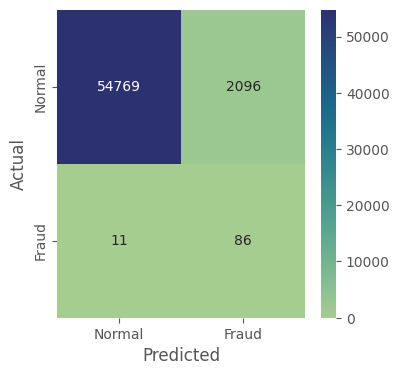

In [60]:
# Obtain the predicted values 
y_predicted_dt_bal_u = dt_grid_u.predict(X_test)

# Evaluate the model
eval_model(y_predicted_dt_bal_u, y_test)

**Oversampling**

The same process is repeated with oversampling

*The following grid search has been commented out since it takes too long. The saved state can be loaded.*

In [61]:
# # Run GridSearch with cross-validation
# dt_grid_o = GridSearchCV(ImbPipeline([
#     ('oversampling', SMOTE(sampling_strategy = 'minority', random_state = 37)),
#     ('dt', DecisionTreeClassifier())
# ]), 
#         param_grid_dt, cv=folds, scoring = 'f1', verbose = 3)

# dt_grid_o.fit(X_train, y_train)

In [62]:
# Load the model -- make sure edit the file path to where the pkl file has been saved
dt_grid_o = joblib.load('./saved_objects/decision_tree_oversampling_param_search.pkl')

In [63]:
# Best parameters and score
print(f"Best Parameters: {dt_grid_o.best_params_}")
print(f"Best F1 Score: {dt_grid_o.best_score_:.4f}")

Best Parameters: {'dt__max_depth': None, 'dt__max_features': 'log2', 'dt__min_samples_split': 2}
Best F1 Score: 0.5876


Interestingly, not setting any max_depth for the tree returns the best performance. However, the maximum number of features are best limited at log 2. The minimal samples are also best 2. 

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [64]:
# # Save the model to a file
# joblib.dump(dt_grid_o, './saved_objects/decision_tree_oversampling_param_search.pkl')

Precision: 0.383
Recall: 0.794
F1-score: 0.517


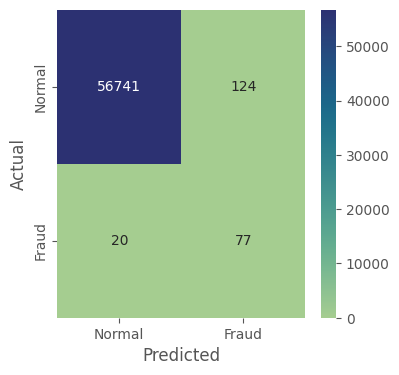

In [65]:
# Obtain the predicted values 
y_predicted_dt_bal_o = dt_grid_o.predict(X_test)

# Evaluate the model 
eval_model(y_predicted_dt_bal_o, y_test)

Oversampling for decision tree performs better than other data balancing methods/algorithms in the previous iteration. However, this still has a lower performance than the decision tree without any data balancing.

In [66]:
# Save for future reference (results summary)
all_y_preds['Decision Tree (Undersampling)'] = y_predicted_dt_bal_u
all_y_preds['Decision Tree (Oversampling)'] = y_predicted_dt_bal_o

### 4.2 (extension) Tree-Based Ensembling

As an extension to decision trees, tree-based ensembling methods are also explored to see if they improve decision tree's performance. In theory, ensembling methods aim to reduce variance and thus reduce overfitting and improve model's performance. The two well-known ensemling methods experimented here are Bagging and Boosting. 

In [67]:
# Create our base using our best decision tree model so far
base_dt = DecisionTreeClassifier(max_depth=6, max_features=None, min_samples_split = 4)

#### 4.2.1 Bagging

Bagging is short for "bootstrap aggregating", which simply samples rows from our dataset several times to build multiple trees. The final predicted output is computed by taking an average of the prediction of all of our bootstrapped trees. We test out this method as follows. 

*A bagging classifier also takes long to train, so the code has been commented out. The saved model can be loaded.*

In [68]:
# # Initialize the BaggingClassifier with the base model
# bagging_clf = BaggingClassifier(base_dt, random_state=37)

# # Train the model with training data 
# bagging_clf.fit(X_train, y_train)

In [69]:
# Load the saved model from the file -- make sure edit the file path to where the pkl file has been saved
bagging_clf = joblib.load('./saved_objects/bagging_model.pkl')

Precision: 0.888
Recall: 0.814
F1-score: 0.849


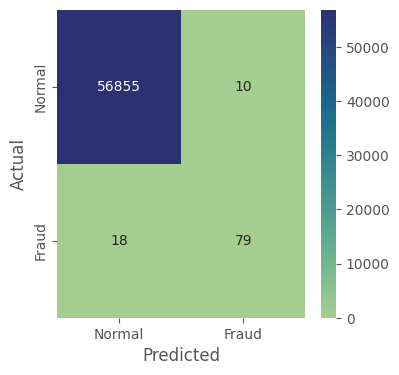

In [70]:
# Obtain the predicted outputs 
y_predicted_bag = bagging_clf.predict(X_test)

# Evaluate the model 
eval_model(y_predicted_bag, y_test)

There is no improvement seen with bagging. The performance is roughly the same. 

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [71]:
# # Save the model
#  joblib.dump(bagging_clf, './saved_objects/bagging_model.pkl')

In [72]:
# Save for future reference (results summary)
all_y_preds['Bagging'] = y_predicted_bag

#### 4.2.2 Balanced Bagging Classifier

An extension of Bagging also involves a balanced bagging classifier which aims to balance the dataset during the boostrapping stage of the algorithm. 

*A bagging classifier also takes long to train, so the code has been commented out. The saved model can be loaded.*

In [73]:
# # Initialize the BalancedBaggingClassifier with the base model
# bb_clf = BalancedBaggingClassifier(estimator=base_dt,
#                                 sampling_strategy='not majority',
#                                 replacement=False,
#                                 random_state=37)

# # Train the model with training data 
# bb_clf = bb_clf.fit(X_train, y_train)

In [74]:
# Load the saved model from the file -- make sure edit the file path to where the pkl file has been saved
bb_clf = joblib.load('./saved_objects/balanced_bagging_model.pkl')

Precision: 0.885
Recall: 0.794
F1-score: 0.837


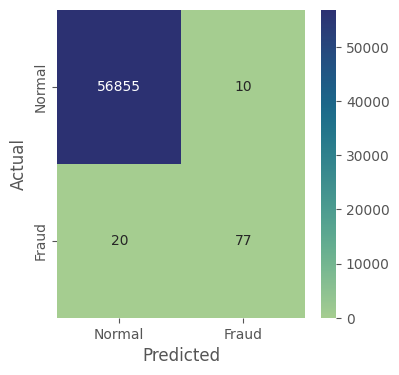

In [75]:
# Obtain the predicted outputs 
y_predicted_bb = bb_clf.predict(X_test)

# Evaluate the model 
eval_model(y_predicted_bb, y_test)

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [76]:
# joblib.dump(bb_clf, './saved_objects/balanced_bagging_model.pkl')

A balanced bagging has also slightly worsened the performance of the model (but not as worse as other data balancing methods)

In [77]:
# Save for future reference (results summary)
all_y_preds['Balanced Bagging'] = y_predicted_bb

#### 4.2.3 Boosting


Lastly, boosting is tested, particularly AdaBoost, which iteratively builts on a weak learner and focuses on improving performance on misclassified examples (for more details see report). 

*A boosting classifier also takes long to train, so the code has been commented out. The saved model can be loaded.*

In [78]:
# # Initialize the AdaBoostClassifier with the base model
# boosting_clf = AdaBoostClassifier(base_dt, random_state=37)

# # Train the model with training data 
# boosting_clf = boosting_clf.fit(X_train, y_train)

In [79]:
# Load the saved model from the file -- make sure edit the file path to where the pkl file has been saved
boosting_clf = joblib.load('./saved_objects/boosting_model.pkl')

Precision: 0.974
Recall: 0.763
F1-score: 0.855


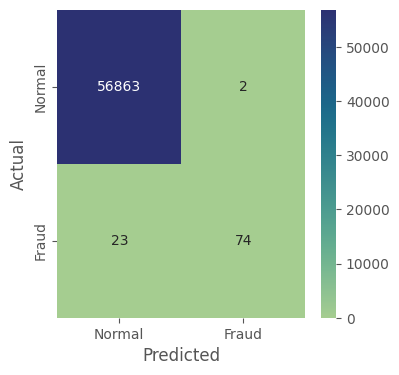

In [80]:
# Obtain the predicted outputs 
y_predicted_boost = boosting_clf.predict(X_test)

# Evaluate model on test set 
eval_model(y_predicted_boost, y_test)

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [81]:
# joblib.dump(boosting_clf, './saved_objects/boosting_model.pkl')

Boosting shows a better result than bagging and also shows some improvement as compared to just using a single decision tree.

In [82]:
# Save for future reference (results summary)
all_y_preds['Boosting'] = y_predicted_boost

### 4.3 Support Vector Machine (SVM)

Support Vector Machine (SVM) is an algorithm that separates data points of each class by finding a separating hyperplane to separate the data points of each of the class. The SVM implemented here makes use of kernels i.e. Kernel SVM as seen in class. In this notebook, the following kernels of SVM are explored: 
- Linear kernel (effectively same as SVM without any kerenel)
- Polynomial kernel 
- Radial basis function kernel (a more general form of gaussian)

SVM can be affected by the scale of data points. SVM makes use of distance-based methods which makes it susceptible to being adversely affected by the magnitutde of the feature values. 

As such, before proceeding with SVM, the data points will need to be scaled. 

Just like before, a standard scaler is incorporated into the model's pipeline. 

#### 4.3.1 Linear Kernel

A linear kernel is first explored using the [LinearSVC](https://scikit-learn.org/1.5/modules/generated/sklearn.svm.LinearSVC.html) class of scikit-learn. A linear kernel is essentially same as doing SVM without any kernel. 

*A linear SVM also takes long to train, so the code has been commented out.*

In [83]:
# svm_lin_clf = Pipeline([
#     ('scaled', StandardScaler()), 
#     ('lin_svm', LinearSVC())
# ])

# svm_lin_clf.fit(X_train, y_train)

The following hyperparamters are tuned: 
- Regularization: L1 and L2 (no option for no penalty)
- Regularization parameter (C): 0.01, 0.01, 1, 10

In [84]:
# Define parameter grid for tuning
param_grid_svm_lin = {
    'lin_svm__penalty': ['l1', 'l2'],
    'lin_svm__C': [0.01, 0.1, 1, 10]
}

*The following grid search has been commented out since it takes too long. The saved state can be loaded.*

In [85]:
# # Run GridSearch with cross-validation
# svm_lin_grid = GridSearchCV(Pipeline([
#     ('scaled', StandardScaler()), 
#     ('lin_svm', LinearSVC())
# ]),
#                         param_grid_svm_lin, cv=folds, scoring = 'f1', verbose = 3)
# svm_lin_grid.fit(X_train, y_train)

In [86]:
# Load the saved model from the file -- make sure edit the file path to where the pkl file has been saved
svm_lin_grid = joblib.load('./saved_objects/svm_lin_param_search.pkl')

In [87]:
# Best parameters and score
print(f"Best Parameters: {svm_lin_grid.best_params_}")
print(f"Best F1 Score: {svm_lin_grid.best_score_:.4f}")

Best Parameters: {'lin_svm__C': 1, 'lin_svm__penalty': 'l2'}
Best F1 Score: 0.7082


The best regularization parameters are found to be the default values of l2 penalty with regularization parameter of 1.

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [88]:
# # Save the model to a file
# joblib.dump(svm_lin_grid, './saved_objects/svm_lin_param_search.pkl')

Precision: 0.897
Recall: 0.536
F1-score: 0.671


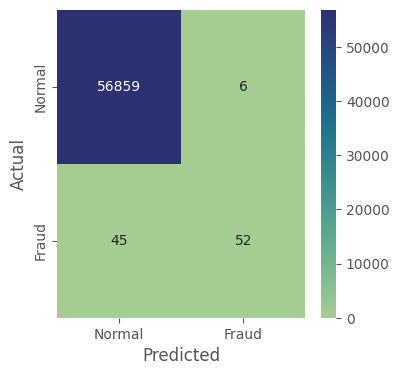

In [89]:
# Obtain the predicted values
y_predicted_svm_lin_tuned = svm_lin_grid.predict(X_test)

# Evaluate the model
eval_model(y_predicted_svm_lin_tuned, y_test)

The performance of linear SVM is not as good as logistic regression/decision tree.

In [90]:
# Save for future reference (results summary)
all_y_preds['Linear SVM'] = y_predicted_svm_lin_tuned

Data balancing is also explored for linear SVM

**Undersampling**

*The following grid search has been commented out since it takes too long. The saved state can be loaded.*

In [91]:
# # Run GridSearch with cross-validation
# svm_lin_grid_u = GridSearchCV(ImbPipeline([
#     ('undersampling', RandomUnderSampler(random_state = 37)),
#     ('scaled', StandardScaler()),
#     ('lin_svm', LinearSVC())
# ]), 
#         param_grid_svm_lin, cv=folds, scoring = 'f1', verbose = 3)

# svm_lin_grid_u.fit(X_train, y_train)

In [92]:
# Load the model -- make sure edit the file path to where the pkl file has been saved
svm_lin_grid_u = joblib.load('./saved_objects/svm_lin_undersampling_param_search.pkl')

In [93]:
# Best parameters and score
print(f"Best Parameters: {svm_lin_grid_u.best_params_}")
print(f"Best F1 Score: {svm_lin_grid_u.best_score_:.4f}")

Best Parameters: {'lin_svm__C': 0.01, 'lin_svm__penalty': 'l1'}
Best F1 Score: 0.4560


Like logistic regression, with undersampling, l1 penalty gives better performance. The best regularization parameter is 0.01

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [94]:
# # Save the model to a file
# joblib.dump(svm_lin_grid_u, './saved_objects/svm_lin_undersampling_param_search.pkl')

Precision: 0.193
Recall: 0.856
F1-score: 0.315


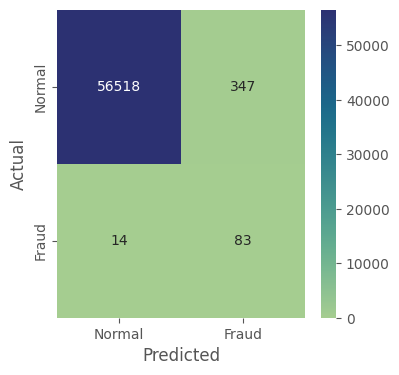

In [95]:
# Obtain the predicted values 
y_predicted_svm_lin_bal_u = svm_lin_grid_u.predict(X_test)

eval_model(y_predicted_svm_lin_bal_u, y_test)

In [96]:
# Save for future reference (results summary)
all_y_preds['Linear SVM (Undersampling)'] = y_predicted_svm_lin_bal_u

**Oversampling**

*The following grid search has been commented out since it takes too long. The saved state can be loaded.*

In [97]:
# # Run GridSearch with cross-validation
# svm_lin_grid_o = GridSearchCV(ImbPipeline([
#     ('oversampling', SMOTE(sampling_strategy = 'minority', random_state = 37)),
#     ('scaled', StandardScaler()),
#     ('lin_svm', LinearSVC())
# ]), 
#         param_grid_svm_lin, cv=folds, scoring = 'f1', verbose = 3)

# svm_lin_grid_o.fit(X_train, y_train)

In [98]:
# Load the model -- make sure edit the file path to where the pkl file has been saved
svm_lin_grid_o = joblib.load('./saved_objects/svm_lin_oversampling_param_search.pkl')

In [99]:
# Best parameters and score
print(f"Best Parameters: {svm_lin_grid_o.best_params_}")
print(f"Best F1 Score: {svm_lin_grid_o.best_score_:.4f}")

Best Parameters: {'lin_svm__C': 1, 'lin_svm__penalty': 'l2'}
Best F1 Score: 0.2543


The best hyperparamters as same as those of linear SVM without any data balancing (the defaults). 

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [100]:
# # Save the model to a file
# joblib.dump(svm_lin_grid_o, './saved_objects/svm_lin_oversampling_param_search.pkl')

Precision: 0.151
Recall: 0.918
F1-score: 0.259


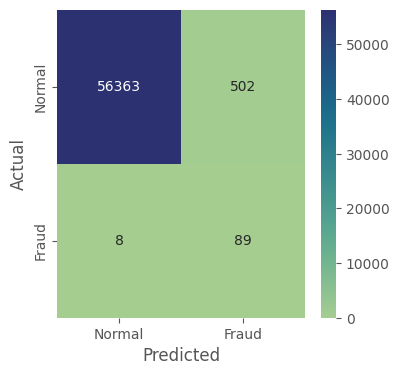

In [101]:
# Obtain the predicted values 
y_predicted_svm_lin_bal_o = svm_lin_grid_o.predict(X_test)

eval_model(y_predicted_svm_lin_bal_o, y_test)

Once again, data balancing worsens performance. Linear SVM without any data balancing performs better, though still not as good as logistic regression or decision tree. The next section will see if other kernels improve performance for SVM.

In [102]:
# Save for future reference (results summary)
all_y_preds['Linear SVM (Oversampling)'] = y_predicted_svm_lin_bal_o

#### 4.3.2 Other Kernels

Let's try SVM with a other kernels using scikit-learn's [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). By default, RBF kernel is used. The kernel choice will be experimented further in they hyperamater tuning stage.

*SVM takes long to train so the folloiwng code has been commented out.*

In [103]:
# svm_non_lin_clf = Pipeline([
#     ('scaled', StandardScaler()), 
#     ('non_lin_svm', SVC())  #default uses a RBF kernel
# ])

# svm_non_lin_clf.fit(X_train, y_train)

The following hyperparamters are tuned: 
- Kernel choice: Polynomial and RBF
- Regularization parameter (C): 0.1, 1, 10   (the regularization here is a squared l2 penalty)

In [104]:
# Define parameter grid for tuning
param_grid_svm_nl = {
    'non_lin_svm__kernel': ['poly', 'rbf'],
    'non_lin_svm__C': [0.1, 1, 10]
}

*The following grid search has been commented out since it takes too long. The saved state can be loaded.*

In [105]:
# # Run GridSearch with cross-validation
# svm_nonlin_grid = GridSearchCV(Pipeline([
#     ('scaled', StandardScaler()), 
#     ('non_lin_svm', SVC())  #default uses a RBF kernel
# ]), 
#         param_grid_svm_nl, cv=folds, scoring = 'f1', verbose = 3)

# svm_nonlin_grid.fit(X_train, y_train)

In [106]:
# Load the model -- make sure edit the file path to where the pkl file has been saved
svm_nonlin_grid = joblib.load('./saved_objects/svm_non_lin_param_search.pkl')

In [107]:
# Best parameters and score
print(f"Best Parameters: {svm_nonlin_grid.best_params_}")
print(f"Best F1 Score: {svm_nonlin_grid.best_score_:.4f}")

Best Parameters: {'non_lin_svm__C': 1, 'non_lin_svm__kernel': 'poly'}
Best F1 Score: 0.8175


Polynomial kernel performs the best with the default regularization parameter of 1. 

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [108]:
# # Save the model to a file
# joblib.dump(svm_nonlin_grid, './saved_objects/svm_non_lin_param_search.pkl')

Precision: 0.877
Recall: 0.732
F1-score: 0.798


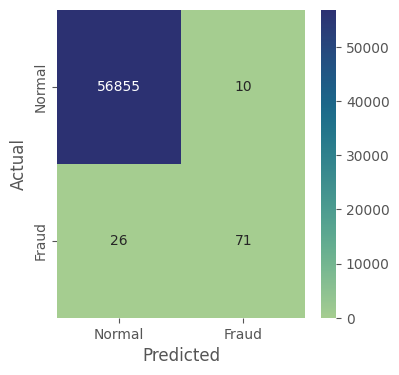

In [109]:
# Obtain the predicted values 
y_predicted_svm_non_lin_tuned = svm_nonlin_grid.predict(X_test)

eval_model(y_predicted_svm_non_lin_tuned, y_test)

The performance of SVM with apolynomial kernal is significantly better than a linear kernel. One last time, we try data balancing methods and see what difference they make

In [110]:
# Save for future reference (results summary)
all_y_preds['Kernel (Polynomial) SVM'] = y_predicted_svm_non_lin_tuned

#### Data Balancing

**Undersampling**

*The following grid search has been commented out since it takes too long. The saved state can be loaded.*

In [111]:
# # Run GridSearch with cross-validation
# svm_nonlin_grid_u = GridSearchCV(ImbPipeline([
#     ('undersampling', RandomUnderSampler(random_state = 37)),
#     ('scaled', StandardScaler()),
#     ('non_lin_svm', SVC())
# ]), 
#         param_grid_svm_nl, cv=folds, scoring = 'f1', verbose = 3)

# svm_nonlin_grid_u.fit(X_train, y_train)

In [112]:
# Load the model -- make sure edit the file path to where the pkl file has been saved
svm_nonlin_grid_u = joblib.load('./saved_objects/svm_non_lin_undersampling_param_search.pkl')

In [113]:
# Best parameters and score
print(f"Best Parameters: {svm_nonlin_grid_u.best_params_}")
print(f"Best F1 Score: {svm_nonlin_grid_u.best_score_:.4f}")

Best Parameters: {'non_lin_svm__C': 1, 'non_lin_svm__kernel': 'poly'}
Best F1 Score: 0.2460


*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [114]:
# # Save the model to a file
# joblib.dump(svm_nonlin_grid_u, './saved_objects/svm_non_lin_undersampling_param_search.pkl')

Precision: 0.138
Recall: 0.711
F1-score: 0.232


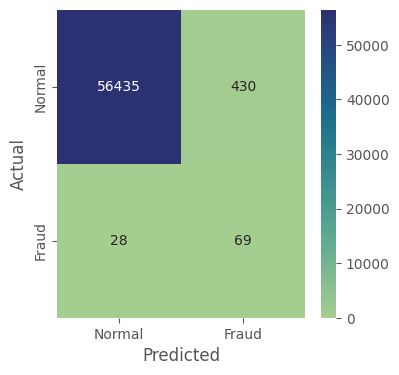

In [115]:
# Obtain the predicted values 
y_predicted_svm_nonlin_bal_u = svm_nonlin_grid_u.predict(X_test)

# Evalute the model
eval_model(y_predicted_svm_nonlin_bal_u, y_test)

In [116]:
# Save for future reference (results summary)
all_y_preds['Kernel (Polynomial) SVM (Undersampling)'] = y_predicted_svm_nonlin_bal_u

**Oversampling**

Oversampling took extremely long to run (over a day). With the time constraints of this project, the results were not obtained. However, based on the previous results of data balancing seen. It is inferred that it most likely did not improve the performance of SVM.  

In [117]:
# # Run GridSearch with cross-validation
# svm_nonlin_grid_o = GridSearchCV(ImbPipeline([
#     ('oversampling', SMOTE(sampling_strategy = 'minority', random_state = 37)),
#     ('scaled', StandardScaler()),
#     ('non_lin_svm', SVC())
# ]), 
#         param_grid_svm_nl, cv=folds, scoring = 'f1', verbose = 3)

# svm_nonlin_grid_o.fit(X_train, y_train)

In [118]:
# # Load the model 
# svm_nonlin_grid_o = joblib.load('./saved_objects/svm_non_lin_oversampling_param_search.pkl')

In [119]:
# # Best parameters and score
# print(f"Best Parameters: {svm_nonlin_grid_o.best_params_}")
# print(f"Best F1 Score: {svm_nonlin_grid_o.best_score_:.4f}")

In [120]:
# # Save the model to a file
# joblib.dump(svm_nonlin_grid_o, './saved_objects/svm_non_lin_oversampling_param_search.pkl')

In [121]:
# # Obtain the predicted values 
# y_predicted_svm_nonlin_bal_o = svm_nonlin_grid_o.predict(X_test)

In [122]:
# eval_model(y_predicted_svm_nonlin_bal_o, y_test)

## 5. Unsupervised/Semi-Supervised Learning (Anomaly Detection)

In Section 5, the fraud detection is viewed a semi-supervised, anomaly detection problem. Fraudulent transactions often tend to be out of the norm from all of the other normal transactions. As such, normal transactions patterns are modeled with unsupervised learning algorithm, after which an optimal threshold to distinguish between normal and anmolaous transactions is obtained. The optimal threshold is calculated by testing out a range of thresholds on the validation set labels and determining which threshold gives the best F1-score. The final model performance is then evaluated using the normal transaction representation and the optimal threshold to assign labels to the test data. 

The algorithms explored in this section are: 
- 5.1: K-means Clustering 
- 5.2: Gaussian Mixture Model 
- 5.3: Autoencoders

***Remark:*** *Data balancing methods are not considered for any of the algorithms in this section since the nature of the problem requires anomalies to be "rare" and to be sieved out from the normal occurences. Standardization to zero norm and unit variance are applied to all of them since all algorithms either use distance-based measures or have normality assumptions.*

### 5.1 K-means Clustering

K-means clustering is first explored to represent the normal transactions. K-means has been discussed in class as a clustering algorithm that clusters similar data points together, where each cluster is represented by a summary value such as centroid. K-means clustering can also be formulated as an anomaly detection algorithm, where points that are “too far” from the cluster centroid could be classified as an anomaly. Classes that are too far are defined by a percentile `p`, where if the distance between a point and the nearest cluster centorid (i.e. the assigned cluster) exceeds the top `p`% of the distance of all points from its cluster centers, then the point is labelled as an anomaly (i.e. `Class` = 1, fraudulent transaction). 

*Note that we also data is to scaled since K-means clustering uses distance based methods and will be sensitive to differences in magnitude.*

A K-means anomaly detection model is built in the following manner: 
1. Set a the range of threshold values and value of K clusters to experiment with. 
2. Conduct cross validation. For each value of K, 
- 2a) 4-folds of the training set are taken. <br>
- 2b) For each fold, take only the normal transactions of the training data to fit a K-clustering model with the current value of K and obtain the best percentile threshold for the current value of K. <br>
-  2c) Get the CV score (average F1 score on all folds) for each percentile threshold tested. Store the percentile threshold that gives the best CV score for the current value of K <br>
3. The best overall K value and percentile threshold is obtained where any percentile threshold gives the best CV score across any value of K. 

#### Hyperparameter & Threshold Tuning 

In [123]:
# Range of percentile thresholds to test
percentile_thres = np.arange(90, 100, 0.1)

# Range of K values to test for K-cluster
param_grid_kmeans = {
    'n_clusters': [2, 3, 4, 5, 6, 7]
}

The cross validation is implemented with custom for loops as follows:

In [124]:
# Dictionary to store best percentile threshold and F1 score for each value of K
param_thresh_f1_kmeans = {}

# Loop through different values of K in the parameter grid
for clust in tqdm(param_grid_kmeans['n_clusters'], desc="Clustering Progress", colour = 'green'): 
    #Initialize dictionary to store F1 scores for each percentil threshold
    percentile_f1s = {key: [] for key in percentile_thres}

    # Cross-validation
    for train_idx, valid_idx in folds.split(X_train, y_train):
        # Split the original training data into the training and validation data with the current fold
        X_training, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_training, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # Initialize a K-means clustering model
        model = Pipeline([
            ('scaler', StandardScaler()),  # Step 1: Scale features to zero norm and unit variance
            ('kmeans', KMeans(n_clusters=clust, random_state=37)) # Step 2: Apply K-means clustering with current paramters
            ])
        
        # Train the model only using rows corresponding to normal transactions
        X_train_normal = X_training[y_training == 0]
        model.fit(X_train_normal)

        # Compute minimum distance of each point in the validation data to the closest cluster center
        valid_distances = model.transform(X_valid).min(axis=1)

        # Evaluate different percentile thresholds
        for percentile in percentile_thres:
            # Find the distance threshold based on the current percentile
            curr_thresh = np.percentile(valid_distances, percentile)

            # Predict anomalies based on current threshold (distance >= corresponding distance threshold are 1)
            y_pred = (valid_distances >= curr_thresh).astype(int)

            # Calculate F1-score and store it
            percentile_f1s[percentile].append(f1_score(y_valid, y_pred))
    
    # Calculate average F1 score (CV score) for each percentile threshold across all folds
    average_f1 = {perc: sum(f1s)/len(f1s) for perc, f1s in percentile_f1s.items()}
    # Find percentile threshold with highest F1 score
    best_percentile_f1 = max(average_f1.items(), key = lambda a: a[1])

    # Store best percentile threshold for current value of K 
    param_thresh_f1_kmeans['n_clusters=' + str(clust)] = {'percentile_thresh': best_percentile_f1[0], 
                                                   'avg_f1_score': best_percentile_f1[1]}



Clustering Progress:  33%|███▎      | 2/6 [00:21<00:42, 10.67s/it]

Clustering Progress: 100%|██████████| 6/6 [01:03<00:00, 10.63s/it]


In [125]:
# Find the configuration with the highest average F1 score
best_param_thres_kmeans = max(param_thresh_f1_kmeans.items(), key = lambda a: a[1]['avg_f1_score'])
# Extract the optimal number of clusters from the key
best_cluster_size = int(best_param_thres_kmeans[0].split('=')[1])

# Get the best percentile threshold and corresponding F1 score 
best_percentile_thresh_kmeans = best_param_thres_kmeans[1]['percentile_thresh']
best_val_f1_kmeans = best_param_thres_kmeans[1]['avg_f1_score']

# Print the results
print("Best Cluster Size: ", best_cluster_size)
print("Best Percentile Threshold: ", best_percentile_thresh_kmeans)
print("Best Validation F1-Score: ", best_val_f1_kmeans)

Best Cluster Size:  4
Best Percentile Threshold:  99.89999999999944
Best Validation F1-Score:  0.29382969453028634


The optimal cluster size is found to be K = 4. Let's build a K-means model with that parameter. 

#### Final Testing

In [126]:
kmeans = model = Pipeline([
            ('scaler', StandardScaler()),  # Step 1: Scale features to zero norm and unit variance
            ('kmeans', KMeans(n_clusters=best_cluster_size, random_state=37)) # Step 2: Apply K-means clustering
            ])

kmeans.fit(X_train[y_train == 0])

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=37))])

The distributed of the distances of the point from its centroid are visualized below for both the training set and the testing set.

In [127]:
# Compute the distances on the training set
train_distances = kmeans.transform(X_train).min(axis =1)

# Find the distance that is in the top 99.899 percentile
train_thresh = np.percentile(train_distances, best_percentile_thresh_kmeans)

*Note that the y-axis has been log transformed for better visibility.*

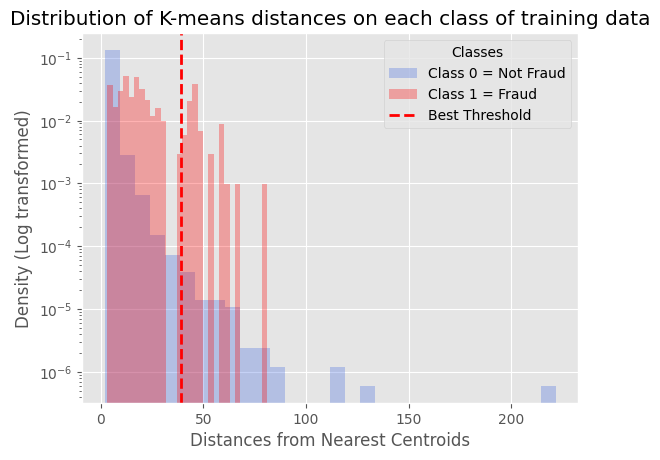

In [128]:
# Histogram of distances from the closest centroid of the normal transactions in the training set
plt.hist(
        train_distances[y_train == 0],
        bins=30, 
        alpha=0.3, 
        label="Class 0 = Not Fraud", 
        color = "royalblue",
        density=True 
    )

# Histogram of distances from the closest centroid of the fraudulent transactions in the training set
plt.hist(
        train_distances[y_train == 1],
        bins=30, 
        alpha=0.3, 
        label="Class 1 = Fraud", 
        color = "red",
        density=True 
    )

# The optimal threshold (in terms of distance) obtained from cross validation
plt.axvline(
    x= train_thresh, 
    color="red", 
    linestyle="--", 
    linewidth=2, 
    label= "Best Threshold"
)

# Log scaling of the y-axis for better visibility of short-height bins
plt.yscale('log')

# Titling of axes and the plot
plt.xlabel('Distances from Nearest Centroids')
plt.ylabel('Density (Log transformed)')
plt.title('Distribution of K-means distances on each class of training data')

# Add and position the legend at the best spot
plt.legend(title="Classes", loc="best")


In [129]:
# Compute the distances on the test set
test_distances = kmeans.transform(X_test).min(axis =1)

# Find the distance that is in the top 99.899 percentile
test_thresh = np.percentile(test_distances, best_percentile_thresh_kmeans)

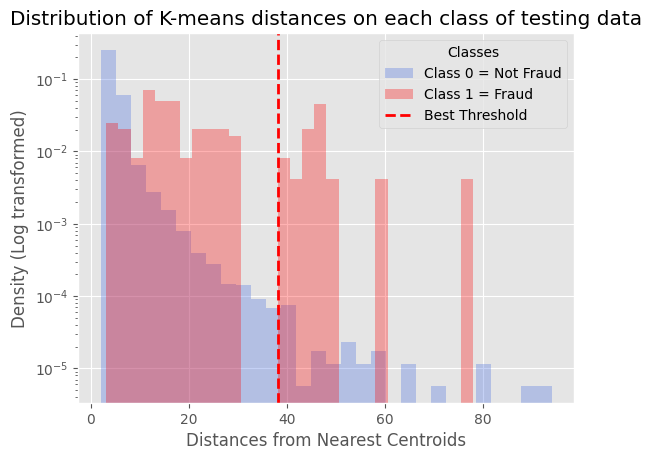

In [130]:
# Histogram of distances from the closest centroid of the normal transactions in the training set
plt.hist(
        test_distances[y_test == 0],
        bins=30, 
        alpha=0.3, 
        label="Class 0 = Not Fraud", 
        color = "royalblue",
        density=True 
    )

# Histogram of distances from the closest centroid of the fraudulent transactions in the training set
plt.hist(
        test_distances[y_test == 1],
        bins=30, 
        alpha=0.3, 
        label="Class 1 = Fraud", 
        color = "red",
        density=True 
    )

# The optimal threshold (in terms of distance) obtained from cross validation
plt.axvline(
    x= test_thresh, 
    color="red", 
    linestyle="--", 
    linewidth=2, 
    label= "Best Threshold"
)

# Log scaling of the y-axis for better visibility of short-height bins
plt.yscale('log')

# Titling of axes and the plot
plt.xlabel('Distances from Nearest Centroids')
plt.ylabel('Density (Log transformed)')
plt.title('Distribution of K-means distances on each class of testing data')

# Add and position the legend at the best spot
plt.legend(title="Classes", loc="best")


As seen by the plots, the threshold seems to identify most of the normal transactions, it misses out a lot of the fraudulent transactions and misclassify them as normal. 

The model can be now evaluated on the tested, with the optimal threshold used to distinguish anomalies. 

In [131]:
# Compute predicted value as 0 and 1 based on distances that exceed the percentile
y_predicted_km = (test_distances >= test_thresh).astype(int)

Precision: 0.386
Recall: 0.227
F1-score: 0.286


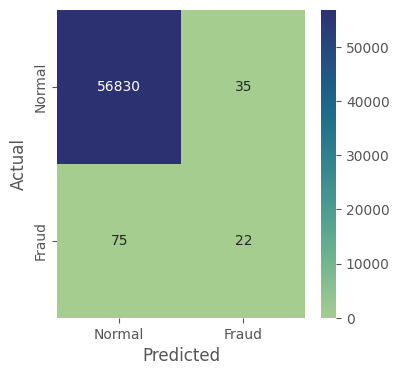

In [132]:
# Evaluate model on test set 
eval_model(y_predicted_km, y_test)

The model has some merit (it is still better than random labelling), but performance is not very impressive as compared to the classification models. The precision and recall are both quite low (though the accuracy is high), which is also suggested by the plots. This may be attributed to the fact that K-means clustering involves a hard assignment of each point only to a single cluster. This provides motivation to explore Gaussian Mixture models. 

In [133]:
# Save for future reference (results summary)
all_y_preds['K-Means Clustering'] = y_predicted_km

### 5.2 Gaussian Mixture Model Forest

The next model used for anomaly detection is a Gaussian Mixture Model. A Gaussian Mixture is a softer version of K-means clustering where points could belong to multiple clusters/normal distributions. Perhaps, this may provide a better representation for the non-fraudulent transactions. The mechanism of the algorithm will also be similar, but instead of using distance, the log likelihood of each point is calculated. Points with log likelihood that are "too low" are flagged as anomalies. The threshold for log likelihood will be tuned with the validation data labels, and final performance will be evaluated on the test set. 

The steps of building of this algorithm will also be similar: 
1. Set a the range of threshold values and value of K components (clusters) to experiment with. 
2. Conduct cross validation. For each value of K (n_components) and the number of initalization to perform (n_init), 
- 2a) 4-folds of the training set are taken. <br>
- 2b) For each fold, take only the normal transactions of the training data to fit a GMM model with the current value of K and obtain the best log likelihood threshold for the current value of K. <br>
-  2c) Get the CV score (average F1 score on all folds) for each threshold tested. Store the threshold that gives the best CV score for the current value of K <br>
3. The best overall K value and  threshold is obtained where any threshold gives the best CV score across any value of K. 

#### Hyperparameter & Threshold Tuning

In [134]:
# Range of log-likelihood thresholds to test
log_like_threshold = np.arange(-500, 0, 5)

# Range of K values to test
param_grid_gmm = {
    'n_components': [1, 3 ,5, 7], 
    'n_init': [1, 3, 5]
}

*The following cross validation has been commented out since it takes too long. The saved state can be loaded.*

In [135]:
# # Dictionary to store the best threshold and F1 score for each value of K
# param_thresh_f1_gmm = {}

# # Loop through diffeent values of K values in the parameter grid
# for component in tqdm(param_grid_gmm['n_components'], colour = 'green'): 
#     # tqdm is used to display progress
#     tqdm.write(f"Component: {component}") 

#     # Loop through different values of number of times to initializae
#     for init in param_grid_gmm['n_init']:
#         #tqdm is used to diplay progress
#         tqdm.write(f"Init: {init}") 
        
#         # Initialize diciontary to store F1 scores for each log-likelihood thresholds
#         thresh_f1s = {key: [] for key in log_like_threshold}

#         # Perform cross-validation using pre-defined folds
#         for train_idx, valid_idx in folds.split(X_train, y_train):
#             # Split training set into training and validation data for current fold
#             X_training, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
#             y_training, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

#             # Initalize a Gaussin Mixture model 
#             model = Pipeline([
#                 ('scaler', StandardScaler()),  # Step 1: Scale features to zero norm and unit variance
#                 ('gmm', GaussianMixture(n_components=component, n_init=init, random_state=37)) # Step 2: Apply Gaussian Mixture with current parameters
#                 ])
        
#             # Train GMM only on rows corresponding to normal transactions
#             X_train_normal = X_training[y_training == 0]
#             model.fit(X_train_normal)

#             # Compute log-likelihood scores for each data point in the validation set
#             valid_scores = model.score_samples(X_valid)

#             # Evaluate different log-likelihood thresholds for anomaly detection
#             for thresh in log_like_threshold:
#                 #Predict anomalies based on current threshold (points below the threshold are anomalous)
#                 y_pred = (valid_scores < thresh).astype(int)

#                 #Compute and store the F1-score
#                 thresh_f1s[thresh].append(f1_score(y_valid, y_pred))
    
#         # Calculate the average F1 score for each threshold across the folds
#         average_f1 = {thres: sum(f1s)/len(f1s) for thres, f1s in thresh_f1s.items()}
#         # Identify the threshold with highest average F1 score (CV score)
#         best_thresh_f1 = max(average_f1.items(), key = lambda a: a[1])

#         # Store the best threshold for current n_component and n_init values
#         param_thresh_f1_gmm[f"n_components= {str(component)}, n_init = {str(init)}"] = {'thresh': best_thresh_f1[0], 
#                                                                                     'avg_f1_score': best_thresh_f1[1]}


In [136]:
# Load results -- make sure edit the file path to where the pkl file has been saved
param_thresh_f1_gmm = joblib.load('./saved_objects/gmm_param_search.pkl')

In [137]:
# Find the K value and n_init value with highest CV score
best_param_thres_gmm = max(param_thresh_f1_gmm.items(), key = lambda a: a[1]['avg_f1_score'])

# Extract optimal parameters corresponding to the highest CV score 
best_n_components = int(best_param_thres_gmm[0].split(',')[0].split('=')[1])
best_n_init = int(best_param_thres_gmm[0].split(',')[1].split('=')[1])

# Find the optimal threshold that gives the highest CV score
best_thresh_gmm = best_param_thres_gmm[1]['thresh']
# The highest CV score
best_val_f1_gmm = best_param_thres_gmm[1]['avg_f1_score']

# Print the results
print("Best Components: ", best_n_components)
print("Best Init: ", best_n_init)
print("Best Threshold: ", best_thresh_gmm)
print("Best Validation F1-Score: ", best_val_f1_gmm)

Best Components:  3
Best Init:  1
Best Threshold:  -400
Best Validation F1-Score:  0.6720936120850456


*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [138]:
# joblib.dump(param_thresh_f1_gmm, './saved_objects/gmm_param_search.pkl')

The best parameters are found to be using 3 clusters for the Gaussian Mixture. Using one initalization is enough. The best threshold is found to be a log likelihood score of -400. 

#### Final Testing

The model is built using these optimal parameters. The entire training set (only with rows of normal transaction) is fitted to the model.

In [139]:
gmm = Pipeline([
                ('scaler', StandardScaler()),  # Step 1: Scale features to zero norm and unit variance
                ('gmm', GaussianMixture(n_components=best_n_components, n_init = best_n_init, random_state=37)) # Step 2: Apply K-means clustering
                ])

gmm.fit(X_train[y_train == 0])

Pipeline(steps=[('scaler', StandardScaler()),
                ('gmm', GaussianMixture(n_components=3, random_state=37))])

The distribution of the log likelihood scores are visualized, both on the training and testing set.

Note that the y-axis has been log transformed for better visibility. 

In [140]:
# Obtain the scores on the entire training set
train_scores = gmm.score_samples(X_train)

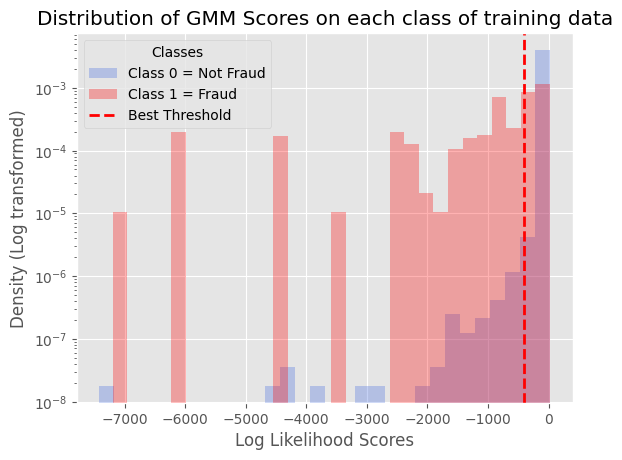

In [141]:
# Histogram of log likelihood values of the normal transactions in the training set
plt.hist(
        train_scores[y_train == 0],
        bins=30, 
        alpha=0.3, 
        label="Class 0 = Not Fraud", 
        color = "royalblue",
        density=True  # Normalizes the histogram
    )

# Histogram of log likelihood values of the fraudulent transactions in the training set
plt.hist(
        train_scores[y_train == 1],
        bins=30, 
        alpha=0.3, 
        label="Class 1 = Fraud", 
        color = "red",
        density=True  # Normalizes the histogram
    )

# The optimal threshold obtained from cross validation
plt.axvline(
    x= best_thresh_gmm, 
    color="red", 
    linestyle="--", 
    linewidth=2, 
    label= "Best Threshold"
)

# Log scaling of the y-axis for better visibility of short-height bins
plt.yscale('log')

# Titling of axes and the plot
plt.xlabel('Log Likelihood Scores')
plt.ylabel('Density (Log transformed)')
plt.title('Distribution of GMM Scores on each class of training data')

# Add and position the legend at the best spot
plt.legend(title="Classes", loc="best")


In [142]:
# Obtain the scores on the testing set
test_scores = gmm.score_samples(X_test)

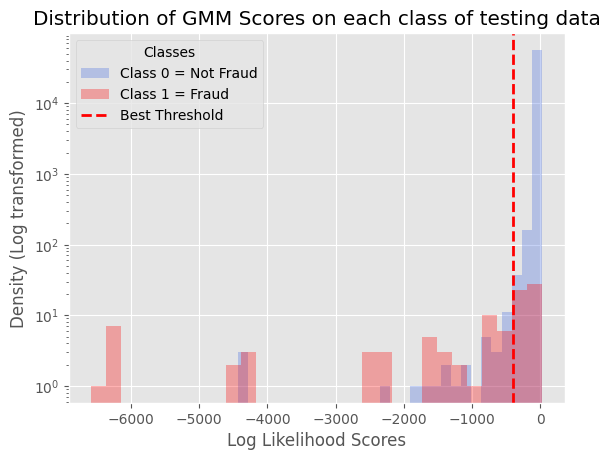

In [143]:
# Histogram of log likelihood values of the normal transactions in the testing set
plt.hist(
        test_scores[y_test == 0],
        bins=30, 
        alpha=0.3, 
        label="Class 0 = Not Fraud", 
        color = "royalblue",
        #density=True  # Normalizes the histogram
    )

# Histogram of log likelihood values of the fraudulent transactions in the testing set
plt.hist(
        test_scores[y_test == 1],
        bins=30, 
        alpha=0.3, 
        label="Class 1 = Fraud", 
        color = "red",
        #density=True  # Normalizes the histogram
    )

# The optimal threshold obtained from cross validation
plt.axvline(
    x= best_thresh_gmm, 
    color="red", 
    linestyle="--", 
    linewidth=2, 
    label= "Best Threshold"
)

# Log scaling of the y-axis for better visibility of short-height bins
plt.yscale('log')

# Titling of axes and the plot
plt.xlabel('Log Likelihood Scores')
plt.ylabel('Density (Log transformed)')
plt.title('Distribution of GMM Scores on each class of testing data')

# Add and position the legend at the best spot
plt.legend(title="Classes", loc="best")


The plots seem to correctly classify most of the normal transactions. It seems to also correctly identify many fraudulent transactions as anomalies and seems to perform better than K-means

The model can be now evaluated on the tested, with the optimal threshold used to distinguish anomalies. 

Precision: 0.593
Recall: 0.526
F1-score: 0.557


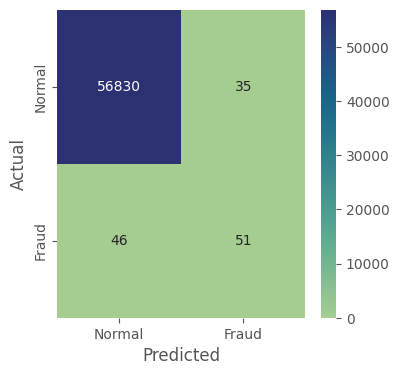

In [144]:
# Evaluate performance on the testing set
y_predicted_gmm = (test_scores < best_thresh_gmm).astype(int)
eval_model(y_predicted_gmm, y_test)

GMM has improved the performance of anomaly detection as compared to K-means clustering. This is most likely because hard assignment into clusters is not a best way to represent the data. In other words, the non-fraudulent transactions probably have rows that "belong to multiple clusters". 

However, the model still does not perform as well as any of the classification models. As seen by the plots, this is most likely because some of the fraudulent transactions still have higher log likelihood scores while some of the normal transactions still have alower log likelihood scores. Although the threshold tries to balance out and find a good separation point, it still does not account for the patterns seen by all of the points in either of the classes. 

In [145]:
# Save for future reference (results summary)
all_y_preds['Gaussian Mixture Model'] = y_predicted_gmm

### 5.3 Autoencoders

The last unsupervised algorithm explored is autencoders. Autoencoders learn data representations using an encoder-decoder architecture. For each data point, a reconstruction error with respect to the learnt latent representation is calculated. This could be useful in anomaly detection, where data points with reconstruction error that are "too high" can be labelled as anomalies. 

*Note that we also data is also scaled for faster convergence of autoencoders.*

Autencoders for anomaly detection model is built in the following manner: 
1. Find autoencoder that forms the best representation for the normal transactions. This is achieved by using cross validation to find the best hyperparameters for the encoder and decoder neural networks. 
2. Once the best parameters are found. Cross validation is once again used to determine the optimal threshold of reconstruction errors. 
3. Final performance with the best autoencoder and best reconstruction error threshold is evaluated on the test set.

#### Hyerparameter Tuning for Autoencoder

The first round of cross validation focuses on finding the best hyperparameters for the neural networks of the encoder and decoder. As such, only the normal transactions are required in this stage (we do not want to include fraudulent transactions in learning the patterns of normal transactions). 

In [146]:
# Sieve out only the normal transactions from the entire training set (to be used for cross validation)
X_train_normal = X_train[y_train == 0]

# Retireve the number of columns. This will be helpful in defining the input layer 
input_dim = X_train_normal.shape[1]

The following hyperparameters are experimented with: 
- Number of units in the hidden layers: A range of values are experimented for each of the 4 hidden layers in the encoder and decoder respectively. 
- Activation function choices: ReLU, Sigmoid, and Tanh (learnt from class) as well as Selu and ELU. While ReLU is generally preferred, [Selu](https://paperswithcode.com/method/selu) and [Elu](https://paperswithcode.com/method/elu#:~:text=The%20Exponential%20Linear%20Unit%20(ELU)%20is%20an%20activation%20function%20for,but%20with%20lower%20computational%20complexity.) activation functions also are shown to have smoother convergence, which may be a better choice for autoencoders. 
- Learning rate: The learning rate may often have effect on the convergence and finding of a local vs global optima. With the [Adam optimizer](https://arxiv.org/abs/1412.6980), a range of learning rates are also experimented.

A custom Python class is defined to set up the model and the hyperparameters to be tested. The class inherits from an existing [HyperModel](https://keras.io/api/keras_tuner/hypermodels/base_hypermodel/#hypermodel-class) class by Keras tuner which allows to create a model by specifying the hyperparameters to be tested. 

In [147]:
class AutoencoderHyperModel(HyperModel): 
    # Define the method to build the model with hyperparameter tuning 
    def build(self, hp):
        """
        Builds and compiles an autoencoder model with hyperparameters defined by the `hp` argument.

        This method defines the architecture and hyperparameters of the autoencoder, including:
        - Activation function for the layers (choices: 'selu', 'elu', 'relu', 'sigmoid', 'tanh').
        - The number of units for each layer (determined by the search space for each layer).
        - The learning rate (selected from a predefined set of values).

        The autoencoder architecture consists of an encoder-decoder structure with multiple dense layers
        and a symmetric design between the encoder and decoder parts.

        The model is compiled using the Adam optimizer with the chosen learning rate, and the mean squared error 
        ('mse') is used as the loss function. The accuracy metric is also tracked during training.

        Args:
            hp: Hyperparameters object containing the search space for hyperparameters.
        
        Returns:
            A compiled Keras Sequential model (autoencoder) ready for training.
        """
        
        ## Define the hyperparameters ## 
        # Activation function
        activation = hp.Choice('activation', values = ['selu', 'elu', 'relu', 'sigmoid', 'tanh'])
        
        # Number of units for each layer, with specified ranges
        units_layer1 = hp.Int('units_layer1', min_value = 16, max_value = 128, step = 16)
        units_layer2 = hp.Int('units_layer2', min_value = 8, max_value = 64, step = 8)
        units_layer3 = hp.Int('units_layer3', min_value = 4, max_value = 32, step = 4)
        units_layer4 = hp.Int('units_layer4', min_value = 2, max_value = 16, step = 16)

        # Learning rate
        learning_rate = hp.Choice('learning_rate', values = [0.0001, 0.001, 0.01, 0.1])

        ## Define the autoencoder architecture ##
        autoencoder = Sequential([
            # input layer, match with the input dimension
            Input(shape = (input_dim, )), 

            #encoder = get latents 
            Dense(input_dim, activation = activation), 
            Dense(units_layer1, activation = activation), 
            Dense(units_layer2, activation = activation), 
            Dense(units_layer3, activation = activation), 
            Dense(units_layer4, activation = activation), 

            #decoder, get reconstruction 
            Dense(units_layer4, activation = activation), 
            Dense(units_layer3, activation = activation), 
            Dense(units_layer2, activation = activation), 
            Dense(units_layer1, activation = activation), 
            Dense(input_dim, activation = activation)
        ])

        # compile the model with Adam optimizer, learning rate 
        # MSE is used for the reconstruction loss
        autoencoder.compile(optimizer=Adam(learning_rate), loss = 'mse', metrics = ["acc"])

        return autoencoder 

Another class is also defined for defining how to run the trials for hyperparameter tuning using cross validation. A custom class needs tobe defined since the tuners provided by the library does not implemented cross validation by default. The class is inherited from the base [Tuner](https://keras.io/api/keras_tuner/tuners/base_tuner/#tuner-class) class of keras tuner.

*Remark: Procedure on where and how to save the model was also required to define since the base Tuner class is set to only raise an error as seen in https://github.com/keras-team/keras-tuner/blob/v1.4.7/keras_tuner/engine/base_tuner.py*

In [148]:
class CVTuner(Tuner): 
    """
    Custom Tuner class for performing cross-validation with Keras Tuner.
    This tuner evaluates model performance using k-fold cross-validation 
    and tracks the best hyperparameters based on validation loss.
    """

    def run_trial(self, trial, X, y, batch_size, epochs, *args, **kwargs): 
        """
        Runs a single trial of the hyperparameter tuning process using cross-validation.

        Args:
            trial (Trial): The current trial object containing hyperparameters to test.
            X (DataFrame): Input features for training and validation.
            y (Series or DataFrame): Labels or targets (not used directly in autoencoder).
            batch_size (int): Batch size for model training.
            epochs (int): Number of epochs for model training.
            *args, **kwargs: Additional arguments passed to the trial.

        Returns:
            None. Updates the oracle with the average validation loss for the trial.
        """
        # List to store validation losses for each fold
        val_losses = []
        # Count for tracking of number of folds
        fold_counter = 0

        # Specify where and how to save the model checkpoints. Create a directory for every trial
        trial_dir = os.path.join(self.project_name, f"trial_{trial.trial_id}")
        os.makedirs(trial_dir, exist_ok=True)
        checkpoint_path = os.path.join(trial_dir, "checkpoint.weights.h5")

        # Perform cross-validation over our defined folds 
        for train_idx, valid_idx in folds.split(X): 
            fold_counter+=1 #increment fold counter by 1 

            # Split into training and vliadation data for the current fold
            X_train_set, X_val_set = X.iloc[train_idx], X.iloc[valid_idx]
            
            # Standardize features for better training stability. 
            # Fit it using only the training data, then use the same transformation to scale the validation data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_set)
            X_valid_scaled = scaler.transform(X_val_set)

            # Build the model using current trial's hyperparameters 
            model = self.hypermodel.build(trial.hyperparameters)
            
            # Fit the model on the current fold's scaled trainin data. Use the validation data as validation.
            # Epochs and batch_size are set based on the input
            model.fit(X_train_scaled, X_train_scaled, 
                      shuffle=True, 
                      epochs=epochs, 
                      batch_size=batch_size,
                      validation_data = (X_valid_scaled,X_valid_scaled), 
                      verbose = 0
            )

            # Evaluate the model on the validation data to obtained reconstruction loss for the normal transactions in validation data
            curr_val_loss, _ = model.evaluate(X_valid_scaled, X_valid_scaled, verbose = 0)
            # Store the loss 
            val_losses.append(curr_val_loss)
            
            # Print the validation loss of current fold for progress tracking
            print(f"Fold {fold_counter}: Val Loss = {curr_val_loss}")
        
        # Calculate CV score = average of the validation losses on all the folds 
        avg_val_loss = np.mean(val_losses)
        # Print the CV score for progress tracking 
        print(f"Trial {trial.trial_id} Avg Val Loss: {avg_val_loss}")

        # Save the model and update the trial's results 
        model.save_weights(checkpoint_path)
        self.oracle.update_trial(trial.trial_id, {'val_loss': avg_val_loss})


    def get_best_hyperparameters(self, *args, **kwargs):
        """
        Retrieves the best hyperparameters from all completed trials.

        Args:
            *args, **kwargs: Additional arguments (not used directly).

        Returns:
            tuple: A tuple containing:
                - best_score (float): The best score (lowest validation loss).
                - best_hyperparameters (dict): The hyperparameters for the trial with the best score.
        """
        # Dictionary to store all trial scores and their hyperparameters
        all_scores = {}
        for trial in self.oracle.trials.values():
            # Score assigned to the trial
            score_key = trial.score
            # Hyperparameters for the trial
            all_scores[score_key] = trial.hyperparameters.values

        # Identify the best score with lowest loss
        best_score = min(all_scores)
        
        # Return the best score and the corresponding hyperparameters
        return best_score, all_scores[best_score]
        

With the classes created, the following tuner is instantiated with our defined hypermodel. Note that instead of grid search, a Bayesian optimization is used instead of the hyperparameter tuning using the [BayesianOptimizationOracle](https://keras.io/api/keras_tuner/oracles/bayesian/) class of keras tuner. 

Bayesian optimization does not evaluate every single combination parameters. Instead it builds aprobablistic model to approximate the objective function (which in this case is the reconstruction loss) and uses it to select the next best hyperparamter. The next hyperparameter to explore is define by the prior and posterior probabilities involved in Bayesian optimization processes. The implementation also aims to balance between exploration and exploitation.  With this, Bayesian optimization is better than grid search as it can converge to best hyperparameters in fewer trials

*Note that by specifying the same project, the trials are simply reloaded from previously saved results. Make sure the project_name folder is in the same directory as this notebook.*

In [149]:
# Tuner is instantiated 
tuner = CVTuner(
    hypermodel = AutoencoderHyperModel(),       #use our custom hypermodel 
    oracle = BayesianOptimizationOracle(objective = 'val_loss', max_trials = 50),       #max trials of 50, and objective is to reduce validation loss
    project_name = 'autoencoder_tuning'     # name specified for saving all trials and checkpoints in directory './autoencoder_tuning/'
)

Reloading Tuner from ./autoencoder_tuning/tuner0.json


In [150]:
# Specify the epochs and batch size 
# Shorter epochs were used in the hyperparamter tuning to gauge the best parameters in just a few epochs
EPOCHS = 20
BATCH_SIZE = 256

*The code below has been commented out to retain the output values. Running the code, however, should not do anything since the trials are already completed and simply loaded from the saved objects.*

In [151]:
# tuner.search(X_train_normal, X_train_normal, batch_size=BATCH_SIZE, epochs=EPOCHS)

In [152]:
best_params = tuner.get_best_hyperparameters()
best_params

(0.6119032651185989,
 {'activation': 'selu',
  'units_layer1': 64,
  'units_layer2': 32,
  'units_layer3': 12,
  'units_layer4': 2,
  'learning_rate': 0.001})

The best hyperparameters use a SELU activation function. The number of hidden units in the hidden layers decreases succesively in the encoder in 64-32-12-2 (and increases successively in 2-12-32-64 for the decoder). The best dimension for latent representations are also tuned at 2. The best learning rate is 0.001. 

#### Threshold Tuning

With the hyperparameters tuned, an autoencoder can be constructed. With this autoencoder model another round of cross validation can be performed to determine the best reconstruction loss threshold to distinguish between normal transactions and anomalies/fraudulent transactions.

Set the various parameters and create a function to build an autoencoder with these parameters. 

In [153]:
# with already having found the best hyperameters, longer epochs are used now to ensure the autoencoder learns the representations well
EPOCHS = 50
BATCH_SIZE = 256

# parameters based on hyperparameter tuning results
ACTIVATION_FUNC = best_params[1]['activation']
HIDDEN_DIM_1 = best_params[1]['units_layer1']
HIDDEN_DIM_2 = best_params[1]['units_layer2']
HIDDEN_DIM_3 = best_params[1]['units_layer3']
HIDDEN_DIM_4 = best_params[1]['units_layer4']
LEARNING_RATE = best_params[1]['learning_rate']


In [154]:
def build_autoencoder(input_shape = input_dim, dim_1 = HIDDEN_DIM_1, dim_2 = HIDDEN_DIM_2, dim_3 = HIDDEN_DIM_3, dim_4 = HIDDEN_DIM_4, 
                      lr = LEARNING_RATE, activation_func = ACTIVATION_FUNC):
    """
    Builds and compiles an autoencoder model with a defined architecture.
    The autoencoder consists of an encoder-decoder structure with multiple dense layers. The model is designed
    to learn a compressed representation of the input data through the encoder and then reconstruct the input 
    data through the decoder. The architecture is symmetric, with the same number of units in the encoder and 
    decoder layers, but the layers gradually reduce in size in the encoder and increase in size in the decoder.

    The model is compiled using the Adam optimizer with a specified learning rate, and the mean squared error 
    ('mse') loss function is used for reconstruction. Accuracy is also tracked as a metric during training.

    Args:
        input_shape (int): The shape of the input data (default is `input_dim`).
        dim_1 (int): The number of units in the first hidden layer of the encoder and decoder (default is `HIDDEN_DIM_1`).
        dim_2 (int): The number of units in the second hidden layer (default is `HIDDEN_DIM_2`).
        dim_3 (int): The number of units in the third hidden layer (default is `HIDDEN_DIM_3`).
        dim_4 (int): The number of units in the fourth hidden layer (default is `HIDDEN_DIM_4`).
        lr (float): The learning rate for the Adam optimizer (default is `LEARNING_RATE`).
        activation_func (str): The activation function to be used for the layers (default is `ACTIVATION_FUNC`).

    Returns:
        model: A compiled Keras Sequential model (autoencoder) ready for training.
    """

    model = Sequential([
        # input layer 
        Input(shape = (input_shape, )), 

        # encoder = latents
        Dense(input_dim, activation = activation_func), 
        Dense(dim_1, activation = activation_func), 
        Dense(dim_2, activation = activation_func), 
        Dense(dim_3, activation = activation_func), 
        Dense(dim_4, activation = activation_func),

        # decoder = reconstruction
        Dense(dim_4, activation = activation_func),
        Dense(dim_3, activation = activation_func), 
        Dense(dim_2, activation = activation_func), 
        Dense(dim_1, activation = activation_func), 
        Dense(input_dim, activation = activation_func)
        ])

    model.compile(optimizer = Adam(lr), 
                    loss = 'mse', 
                    metrics = ["acc"])
    return model

With this, a range of different values forthe reconstruction error threshold are experimented with as follows. The process is similar to what was done for K-means and GMM. 

In [155]:
# Thresholds to test
rec_error_threshold = np.arange(0, 100.2, 0.2)

*The following cross validation has been commented out since it takes too long. The saved state can be loaded.*

In [156]:
# # Dictionary to store the F1 scores from each fold for each threshold
# thresh_f1_ae = {t: [] for t in rec_error_threshold}

# # Loop through different values of threshold 
# for train_idx, valid_idx in tqdm(folds.split(X_train, y_train)):
#     # Split training set into training and validation data for current fold
#     X_training, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
#     y_training, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

#     # Get only the normal transactions from the train data in the fold  
#     X_train_normal = X_training[y_training == 0]

#     # Standardize training data, use same transformation to scale the validation data
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train_normal)
#     X_valid_scaled = scaler.transform(X_valid)

#     # Get only the normal transactions from teh valid data in the fold (for purposes of model training and early stopping)
#     X_valid_normal = X_valid_scaled[y_valid == 0]

#     # Initalize an autoencoder (with optimal parameters)
#     autoenc_model = build_autoencoder()

#     # Fit the autoencoder with the the training set 
#     autoenc_model.fit(X_train_normal, X_train_normal, 
#                       shuffle = True, 
#                       epochs = EPOCHS, 
#                       batch_size = BATCH_SIZE, 
#                       validation_data = (X_valid_normal, X_valid_normal), 
#                       verbose = 0)
    
#     # Compute reconstruction loss scores for each data point in the validation set (for all validation transactions)
#     valid_reconstructions = autoenc_model.predict(X_valid_scaled)

#     # Compute validation MSE/reconstruction lose per row in the numpy array
#     val_mse = np.mean(np.power(X_valid_scaled - valid_reconstructions, 2), axis = 1)

#     # Obtain F1-score for each threshold 
#     for thresh in rec_error_threshold: 
#         # Label points with reconstruction loss higher than the threshold as anomalies
#         y_pred = (val_mse > thresh).astype(int)
#         # Use true labels to compute F1 score and store results 
#         thresh_f1_ae[thresh].append(f1_score(y_valid, y_pred))

# # Compute the CV score (average of F1 score across all folds) for each threshold
# thresh_f1_ae_cv = {key: np.mean(values) for key, values in thresh_f1_ae.items()}

In [157]:
# Load results -- make sure edit the file path to where the pkl file has been saved
thresh_f1_ae_cv = joblib.load('./saved_objects/ae_thresh_search.pkl')

In [158]:
# Find the optimal threshold that gives the highest CV score
best_thresh_ae = max(thresh_f1_ae_cv, key=thresh_f1_ae_cv.get)

# Print the results 
print("Best Threshold: ", best_thresh_ae)

Best Threshold:  23.8


The best threshold is found to be at an MSE/reconstrunction loss value of 23.8.

*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [159]:
# joblib.dump(thresh_f1_ae_cv, './saved_objects/ae_thresh_search.pkl')

#### Final Testing

The final model is built and tested using these optimal hyperparameters and threshold value. The entire training set (only with rows of normal transaction) is fitted to the model.

*The following model training takes slihgtly long, so it has been commented out. The saved state can be loaded.*

In [160]:
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)

In [161]:
# ae_final = build_autoencoder() 

# ae_final.fit(X_train_normal_scaled, X_train_normal_scaled, 
#             shuffle = True, 
#             epochs = EPOCHS, 
#             batch_size = BATCH_SIZE)

In [162]:
# Load results -- make sure edit the file path to where the pkl file has been saved
ae_final = load_model('./saved_objects/autoencoder_model.keras')

/Users/sneha/Documents/Sneha/Academic_Learning/NUS_Masters/DSA5105/Project/dsa5105_proj/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


*The following code was used to save the author's original model. It has been commented out to avoid any undesired overwritting of the shared pkl file.*

In [163]:
# ae_final.save('./saved_objects/autoencoder_model.keras')

The distribution of the reconstrunction loss values are visualized, both on the training and testing set.

Note that the y-axis has been log transformed for better visibility. 

In [164]:
# scale the entire training set (including the fraudulent transactions)
X_train_scaled = scaler.transform(X_train)

# pass the transformed train set through the autoencoder to get the reconstructed result
train_reconstructions = ae_final.predict(X_train_scaled)

# reconstrunction loss 
train_mse = np.mean(np.power(X_train_scaled - train_reconstructions, 2), axis=1)

6403/7121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


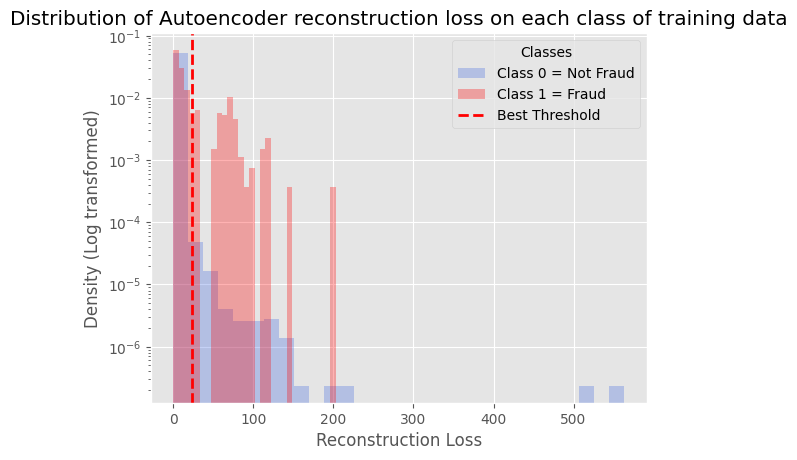

In [165]:
# Histogram of reconstruction loss values of the normal transactions in the training set
plt.hist(
        train_mse[y_train == 0],
        bins=30, 
        alpha=0.3, 
        label="Class 0 = Not Fraud", 
        color = "royalblue",
        density=True  # Normalizes the histogram
    )

# Histogram of reconstruction loss values of the fraudulent transactions in the training set
plt.hist(
        train_mse[y_train == 1],
        bins=30, 
        alpha=0.3, 
        label="Class 1 = Fraud", 
        color = "red",
        density=True  # Normalizes the histogram
    )

# The optimal threshold obtained from cross validation
plt.axvline(
    x= best_thresh_ae, 
    color="red", 
    linestyle="--", 
    linewidth=2, 
    label= "Best Threshold"
)

# Log scaling of the y-axis for better visibility of short-height bins
plt.yscale('log')

# Titling of axes and the plot
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density (Log transformed)')
plt.title('Distribution of Autoencoder reconstruction loss on each class of training data')

# Add and position the legend at the best spot
plt.legend(title="Classes", loc="best")


In [166]:
# scale the test set with the scaler fitted to the training set
X_test_scaled = scaler.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
test_reconstructions = ae_final.predict(X_test_scaled)

# reconstrunction loss 
test_mse = np.mean(np.power(X_test_scaled - test_reconstructions, 2), axis=1)

 259/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


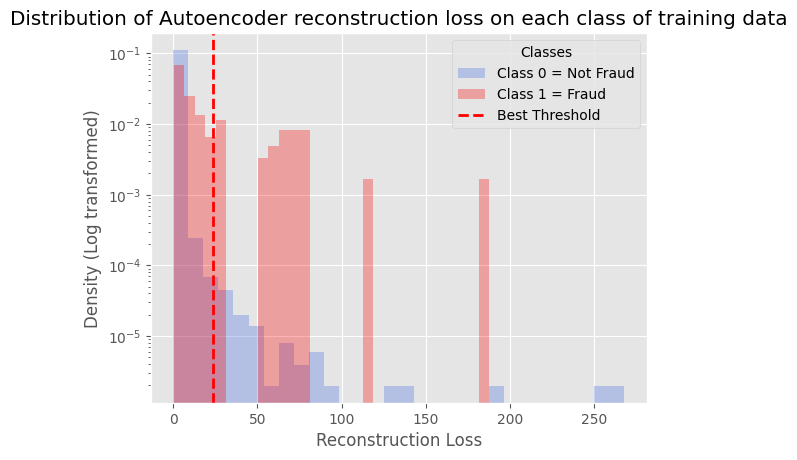

In [167]:
# Histogram of reconstruction loss values of the normal transactions in the testing set
plt.hist(
        test_mse[y_test == 0],
        bins=30, 
        alpha=0.3, 
        label="Class 0 = Not Fraud", 
        color = "royalblue",
        density=True  # Normalizes the histogram
    )

# Histogram of reconstruction loss values of the fraudulent transactions in the testing set
plt.hist(
        test_mse[y_test == 1],
        bins=30, 
        alpha=0.3, 
        label="Class 1 = Fraud", 
        color = "red",
        density=True  # Normalizes the histogram
    )

# The optimal threshold obtained from cross validation
plt.axvline(
    x= best_thresh_ae, 
    color="red", 
    linestyle="--", 
    linewidth=2, 
    label= "Best Threshold"
)

# Log scaling of the y-axis for better visibility of short-height bins
plt.yscale('log')

# Titling of axes and the plot
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density (Log transformed)')
plt.title('Distribution of Autoencoder reconstruction loss on each class of training data')

# Add and position the legend at the best spot
plt.legend(title="Classes", loc="best")


Precision: 0.302
Recall: 0.299
F1-score: 0.301


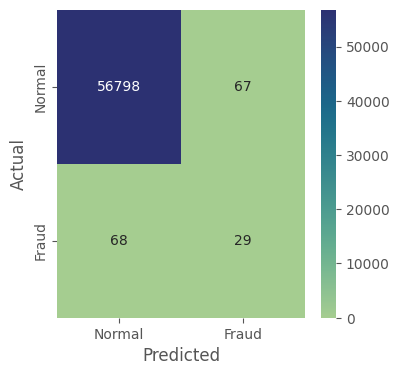

In [168]:
# Points with reconstruction loss/mse above the threshold are labelled as anomalies 
y_predicted_ae = (test_mse > best_thresh_ae).astype(int)
# Evaluate the model 
eval_model(y_predicted_ae, y_test)

As compared to GMM, autoencoders do not show a strong performance. However, it still performs slightly better than K-means. In fact, as shown by the plots, the reconstrunction loss threshold seem to only sieve out the "obvious" anomalies. Interesingly, the reconstrunction of many fraudulent transactions are similar to the reconstrunctions of the normal transactions, which causes the model to miss out many of such fraudulent transactions. 

In [169]:
# Save for future reference (results summary)
all_y_preds['Autoencoders'] = y_predicted_ae

## 6. Final Results and Conclusion 

The summarized results (test metrics) of all the models tested are summarized in the following table.

In [170]:
# Create an empty list to store the evaluation results
evaluation_results = []

# Loop through the dictionary of models and their predictions
for model_name, y_pred in all_y_preds.items():
    # Evaluate the model performance
    f1, precision, recall = eval_model_summary(y_pred, y_test)
    # Append the results to the list
    evaluation_results.append([model_name, precision, recall, f1])

# Create a DataFrame to display the results
eval_df = pd.DataFrame(evaluation_results, columns=['Model', 'Precision', 'Recall', 'F1-Score'])

# Display the evaluation table
print(eval_df)

                                      Model  Precision    Recall  F1-Score
0                       Logistic Regression   0.888889  0.577320  0.700000
1       Logistic Regression (Undersampling)   0.089899  0.917526  0.163753
2        Logistic Regression (Oversampling)   0.089899  0.917526  0.163753
3                             Decision Tree   0.896552  0.804124  0.847826
4             Decision Tree (Undersampling)   0.039413  0.886598  0.075472
5              Decision Tree (Oversampling)   0.383085  0.793814  0.516779
6                                   Bagging   0.887640  0.814433  0.849462
7                          Balanced Bagging   0.885057  0.793814  0.836957
8                                  Boosting   0.973684  0.762887  0.855491
9                                Linear SVM   0.896552  0.536082  0.670968
10               Linear SVM (Undersampling)   0.193023  0.855670  0.314991
11                Linear SVM (Oversampling)   0.150592  0.917526  0.258721
12                  Kerne

Based on the F1-scores, classification models generally perform better than anomaly detection models. In particular, AdaBoost with Decision Tree as the base estimator had the highest F1-score and strongest performance among all the models.

### Summary of Results

While the exact reason of why the classification models performed better than the anomaly detection models is unknown, one can hypothesize it is probably because fraudulent transactions are not always anomalous. Given the rise of technological advancements fraudsters also become smarter in finding more advanced ways to stay hidden and appear “normal”. Although the dataset includes transactions from over 10 years ago, it still makes sense if some of the fraudulent transactions were too good in disguising amongst the normal transactions. The intricacies that still distinguish these disguised fraudulent transactions from the normal transactions, thus, are better captured by classification models. 

Since fraudulent transactions occur in a small proportion and are expected to be anomalies among normal patterns, it is also possible that within this project, not enough anomaly detection algorithms were explored. Some other kinds of anomaly detection algorithms that could be further explored include DBSCAN, which is a density-based clustering algorithm and factors in the density of the points in the cluster, unlike k-means, and automatically classify points that are “too far” as anomalies. Another kind of algorithm that may be worth exploring is variational autoencoders (VAE), which use probabilistic models to learn a latent representation of the data and flag points that are “too deviant” from the data as anomalies. VAE could potentially be better at detecting anomalies, consdering that there is some overlap across the threshold/decision boundary seen in the normal and fraudulent transactions. <br>
Additionaly, perhaps different methods of defining a threshold could also be explored for anomaly detection . In this notebook, rather a strict "linear" threshold was used to distinguish anomalies. A more probabilistic/statistical approach that accounts for the distribution of the anomaly scores could be explored. 

Lastly, an approach that ensembles classification and anomaly detection could also be explored for more a more robust decision-making. It is possible that combining both of these approaches would result in a more superior performance as it would combine the benefits of both approaches. 


### Precision vs Recall

Earlier it has been deduced that classification models perform better, with Boosting performing the best. However, this is derived based on the F1-score, meaning that it assumes both the recall and precision scores are equally important. While this probably holds true in general, it may not always be the case.  

For example, if the credit card fraud detection model is applied in scenarios of luxury item purchases, there is a much larger risk involved for every fraudulent transaction that goes undetected. In such scenario, prioritizing recall scores could be much more important than the precision scores. In such case using  Logistic Regression with data balancing or linear SVM with oversampling would be more ideal. <br>
On the flip side, there could also be scenarios where the credit card fraud detection model is used in a more real-time situation for small, frequent payments such as coffee or grocery that have low risk of financial loss. In such cases, it would be inefficient to have a high number of false positives and thus prioritizing precision may be more important (in the above experiment, Boosing is also the model with the highest precision). <br>

Overall, which of the above models is best suited may widely vary depending on the specific scenario. Based on the specific scenario, either the recall or precision could more prioritized or even a weighted approached to the F1-score calculation could be explored.  

### Limitations

- One of the most obvious limitations presented in this project was the masking of the data variables. Among the fraud detection datasets online, it is very difficult to find data that has both a good number of rows and columns and reveal what each of the variables correspond to. It is possible that knowing what each of the masked columns mean would provide a better understanding of the data and guide towards better heuristics on what experiments should be conducted. 

- Another limitation posed is that the provided dataset only covers credit card fraud transactions of European cardholders and only a span of two days. This affects the generalizability of the model for other time periods, or even to other regions. 


### Conclusion

This project has explored credit card fraud detection from two approaches: 1) a classification task and 2) an anomaly detection task. For classification, logistic regression, decision tree along with ensembling methods, and SVM were explored, while for anomaly detection, k-means clustering, gaussian mixture, and autoencoders were explored. With the assumption that it is equally important to capture as many fraudulent transactions while controlling the number of normal transactions flagged as fraud, the classification models, particularly boosting with AdaBoost (Decision tree as base estimator) performed better. This is most likely because some fraudulent credit card transactions may not be as anomalous since fraudsters tend to disguise themselves among the normal transactions. However, further exploration may be done using more sophisticated anomaly detection algorithms to see if anomaly detection could work better. A more varied dataset that captures credit transactions of a longer time period or even different regions around the world could give a better idea of the model’s generalizability. 

## Extension - Correlation Analysis (Future Work) 

One of the things that was not explored in this notebook was dimensionality reduction and feature selection. This is mostly because the sourced data already had feature vectors obtained from PCA, which suggests that the columns are already the best columns that retain the important information of the original data. However, as an extension, a simple correlation analysis was also conducted

One of the most straightforward ways to gain an idea on how each of the columns are related with each other and the target variable is by computing a correlation matrix across all the columns in the dataset. 

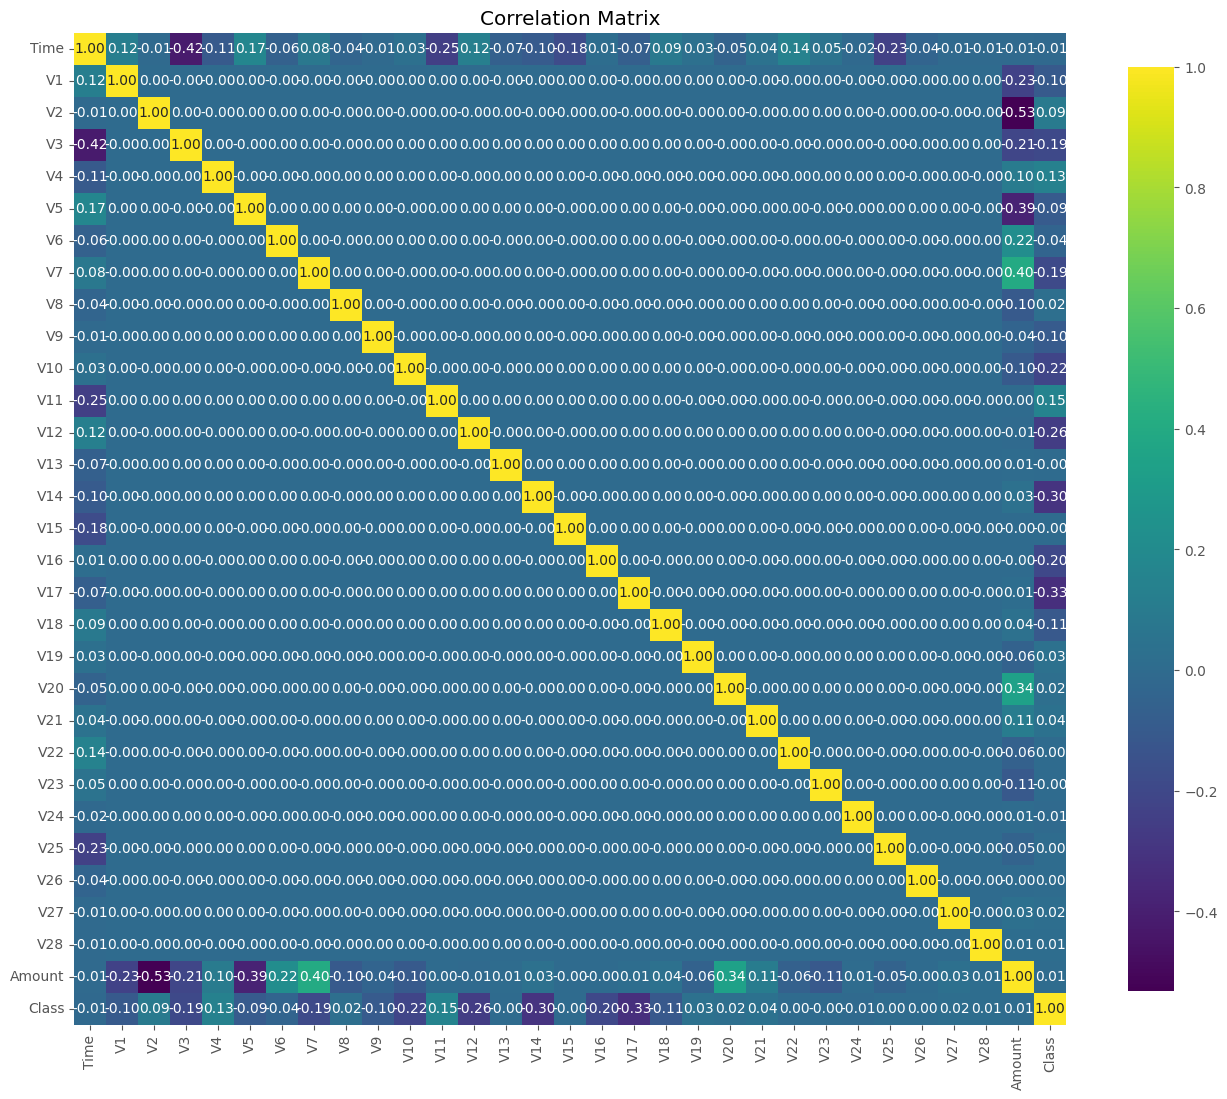

In [171]:
# Compute the correlation matrix
correlation_matrix = fraud_df.corr()

# Set figure size 
plt.figure(figsize=(16,15))       
# Plot the correlation matrix as a heatmap, along with other formatting for annotations and colors 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis", cbar_kws={"shrink": 0.8}, square=True)     
#Set plot title   
plt.title("Correlation Matrix")

#Display the plot
plt.show()


Due to the class imbalance, a lot of of the correlations may not be as obvious. As such, a Robust Correlation Analysis Framework is used, as proposed by [Lai et al. (2018)](https://doi.org/10.1016/j.ins.2018.08.017). Essentially, this approach reduces the impact of class imbalance by creating multiple balanced sets and taking an aggregate correlation value, thus incorporating more of the available data while mitigating the skew that comes from imbalance. 

In [172]:
# Store rows of the two classes separately 
minority_class = fraud_df[fraud_df['Class'] == 1]
majority_class = fraud_df[fraud_df['Class'] == 0]

# Find the length of each class
nb = len(fraud_df[fraud_df['Class'] == 1])
na = len(fraud_df[fraud_df['Class'] == 0])

# Calculate M (number of subsets)
M = int(np.ceil(na / nb))

In [173]:
# Initialize an empty list to store correlation matrices
correlation_matrices = []

# Loop to create M balanced subsets and calculate correlation matrices
for m in range(M):
    # Randomly sample nb instances from the majority class without replacement
    majority_sample = majority_class.sample(n=nb, replace=False)
    
    # Combine with all instances of the minority class to form a balanced subset
    balanced_subset = pd.concat([majority_sample, minority_class])
    
    # Calculate the correlation matrix for this balanced subset
    corr_matrix = balanced_subset.corr()
    correlation_matrices.append(corr_matrix)

# Calculate the averaged correlation matrix
final_correlation_matrix = np.mean(correlation_matrices, axis=0)

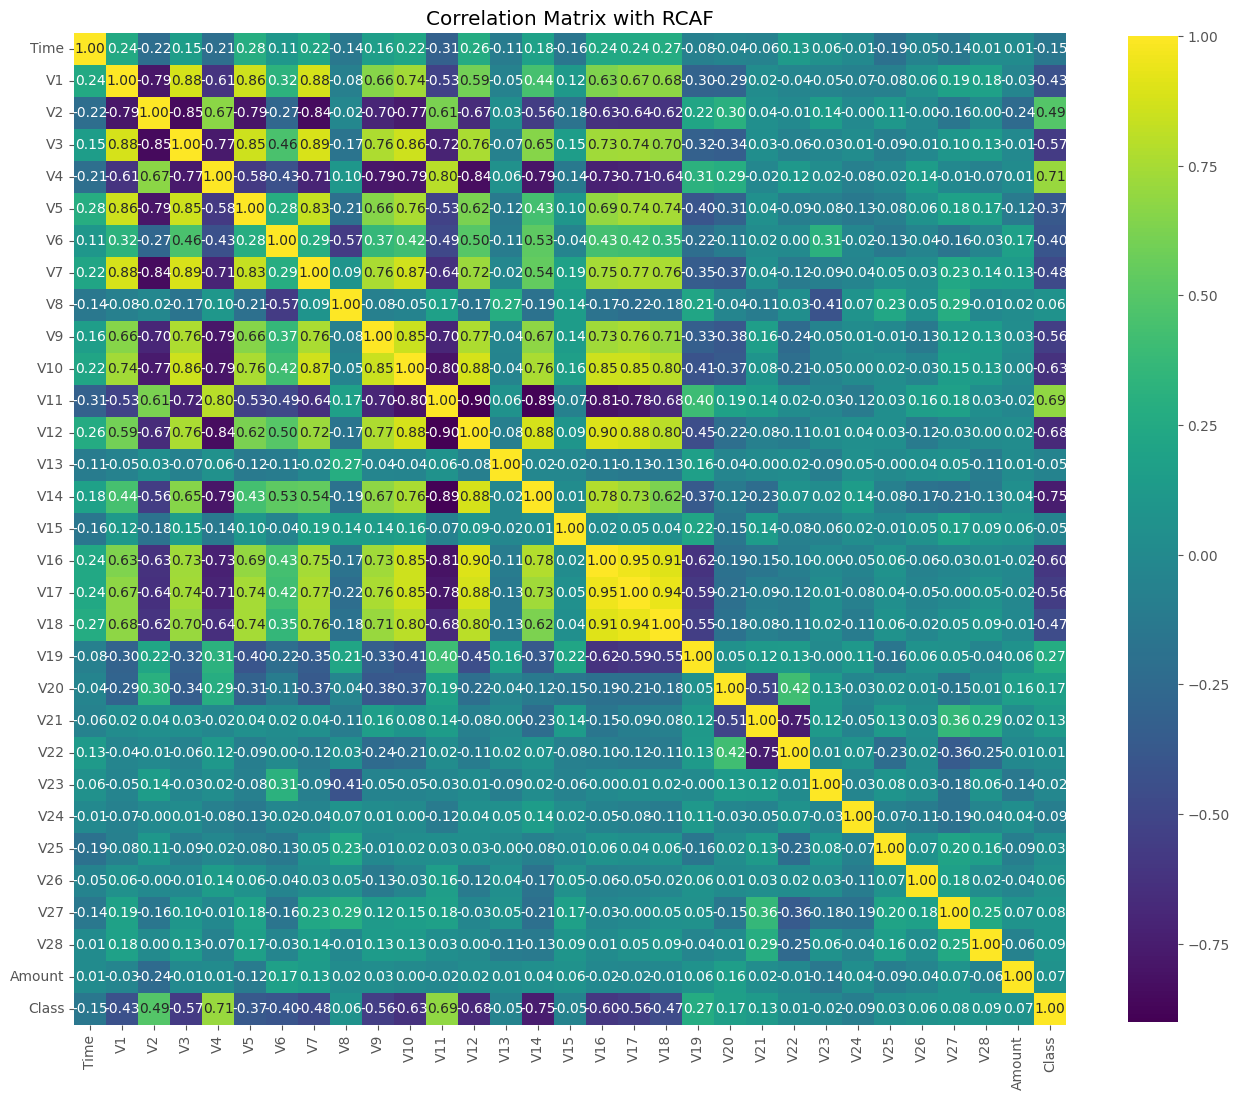

In [174]:
# Plotting the final averaged correlation matrix
plt.figure(figsize=(16, 16))
sns.heatmap(final_correlation_matrix, annot=True, fmt=".2f", cmap="viridis", cbar_kws={"shrink": 0.8}, square=True,
            xticklabels=balanced_subset.columns, yticklabels=balanced_subset.columns)
plt.title("Correlation Matrix with RCAF")
plt.show()


After accounting for the class imabalance and using RCAF, we can more clearly identify correlations between the different columns. A few notable observations: 
- Some columns such as `V4`, `V10`, `V11`, `V12` and `V14` seem to have a somewhat strong correlation with the class of the fraudulent transactions. These columns could potentially considered to be "more important" features.
- Columns `V1`-`V7`, `V9`-`V12`, `V14`, `V16`-`V18` also seem to be intercorrelated. In some cases, training a model with intercorrelated features may cause overfitting. However, dropping some of these features may also cause loss of valuable information in other cases. In general, intercorrelated features do not bring in much new information, but would increase the complexity of a model. 

Asides decision trees, none of the algorithsm are able to inehrently conduct some form of feature selection. As such, this short correlation analysis suggests perhaps conducting feature selection, especially for algorithms like K-means that may suffer from curse of dimensionality, may be beneficial as further exploration. 